In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import Imputer,StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import re
import difflib
import itertools
import matplotlib.cm as cm
import copy
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from scipy.stats import kde,chi2_contingency
import warnings
warnings.filterwarnings('ignore')

## Patterns in Time:

Cats have an annual pattern in terms of their total volume, most likely due to "kitten season".  Dogs do not have such an annual pattern.
There is a weekly pattern to the outcomes for both cats and dogs.

Both cats and dogs are adopted primarily in the evening. On the weekends, the daytime adoption rates increase but the evening remain the busiest times for adoption. The single most important hour for adoptions is 5pm on Sundays.

Cat euthanasia occurs at all times, but there is a distinct pattern of euthanasias occurring in large numbers at 12pm to 1pm on Mondays, at 3pm on Mondays and Tuesdays, at 11am on Tuesdays, and and at 1pm on Saturdays.

Dogs are euthanised primarily on Thursdays at 3pm, with additional euthanasias taking place at 1pm to 2pm on Mondays, 5pm on Wednesdays, and 4pm on Sundays. Dog events occurring at 8am on Mondays and 9pm on Sundays are very likely to be euthanasias.

Transfers show a large number of events at 0 hours both for cats and dogs. This is most likely a result of transfer times not being entered. The majority of actual cat transfers appear to occur at 9am each morning. Dog patterns occur throughout the week at various times, with an obvious elevation at 4pm on a Friday.

Returns appear to happen between 11am and 6pm for both cats and dogs. As with transfers, there is an apparent artifact at 0 hours where time data was probably not entered.

## Animal Ages:
There is an overrepresentation of animals of age 0 being returned to their owners or transferred. This is most likely due to their leaving the shelter before an age could be entered into the system. For both cats and dogs, animals in the puppy/kitten age group seem to be both the most frequent within the shelter, and the most popular for adoption.

## Names:
A cat's name is probably useful to predict the chance of it being adopted, but the effect is not very strong. For dogs, the name appears to be much more important. For example, dogs named Daisy, Lucy, or Buddy seem to have better adoption rates than those named Max, Bella, or Rocky.

## Breeds:

The more common breeds of cats outnumber the rarer ones by more than 1000-fold. Cat breeds do have an effect on outcome, with Domestic Shorthairs (the most common type of breed) being significantly less likely to be adopted or returned to an owner than other breed types.

Almost all of the dogs were mixed breeds. When considering dogs in terms of type ( as defined by The Kennel Club of The United Kingom):

+ Working dogs and dogs of completely unknown types are more likely to be euthanised.
+ Terriers,Gundogs, Pastoral, and Toy Dogs are more likely to be adopted. 
+ Sporting, Hound, and Working dogs are more likely to be returned to their owners (Maybe these dogs are more likely to get lost in the first place if they are being used for hunting etc?). 
+ Utility and Toy dogs have the highest transfer rates.

Scary dogs (ie those breeds I personally consider to be more dangerous) are three times as likely to be euthanised as non-scary dogs, and are also less likely to be adopted. They are however more likely to be returned to their owners. As one would expect, scariness has no effect on a dog's chances of dying from natural causes.

## Colors:
Cats with a rare color are more likely to be euthanised, but there is no obvious reason for this.

**This project will require a lot of grouping and calculating fractions with groups, so I'm going to write a function to make that easy**

In [3]:
def groupCountFractionals(dataframe,target,outer):
    '''
    Returns the fraction of target_criteria_group / outer_criteria_group counts.
    
    Be mindful to take group sizes (Outer Count) into consideration. 
    As outer count gets smaller, the fraction value
    will obviously become increasingly large.
    __________________
    Parameters:
    dataframe: a pandas dataframe
    target: a string corresponding to the column of interest in the dataframe
    outer: a list of the columns by which the counts should be conditioned
    
    '''
    dataframe["Count"] = 1
    outcome_variable = outer[0]
    inner_group_criteria = outer + [target]
    outer_counts = dataframe.groupby(outer).count()[["Count"]]
    outer_counts.columns = ["OuterCount"]
    outer_counts = outer_counts.reset_index()
    inner_counts = dataframe.groupby(inner_group_criteria).count()[["Count"]]
    inner_counts.columns = ["InnerCount"]
    inner_counts = inner_counts.reset_index()
    in_and_out =pandas.merge(inner_counts,outer_counts,on=outer,how="right")
    in_and_out["Fraction"] = in_and_out["InnerCount"] / in_and_out["OuterCount"]
    
    '''The following code is for tracking groups that have counts of zero'''
    group_values = [list(dataframe[o].unique()) for o in outer]
    inner_values = list(dataframe[target].unique())
    group_values.append(inner_values)
    group_permutations = list(itertools.product(*group_values))
    null_df = pandas.DataFrame(group_permutations)
    null_columns = outer.copy()
    null_columns.append(target)
    null_df.columns = null_columns
    
    null_df = pandas.merge(null_df,outer_counts, on = outer,how="outer")
    null_df["InnerCount"] = 0
    null_df["Fraction"] = 0
    
    absent_rows = pandas.merge(null_df,in_and_out,how="outer",on=null_columns,indicator="left_only")
    zero_rows = null_df[absent_rows["left_only"] == "left_only"]
    return pandas.concat([in_and_out,zero_rows]).fillna(0)  



'''Testing the above function'''

testing_df = pandas.DataFrame({
        
        "CriteriaA" : ["A","A",   "B","B",    "C","C"],
        
        "CriteriaB" : ["X","Y",   "X","Y",    "X","Y"],    #Each group in CriteriaA is split 50:50 
                                                           #between CriteriaB's X and Y
        
        "CriteriaC" : ["T","T",   "U","U",    "V","V"]     #CriteriaC splits the groups the same as CriteriaA
        
        
    })
testing_dfA_C = pandas.DataFrame({
        "CriteriaA": ["A","A","A","B","B","B","C","C","C"],
        
        "CriteriaC": ["T","U","V","T","U","V","T","U","V"],
        
        "InnerCount":[ 2,  0,  0,  0,  2,  0,  0,  0,  2],
        
        "OuterCount":[ 2,  2,  2,  2,  2,  2,  2,  2,  2],
        
        "Fraction":  [ 1,  0,  0,  0,  1,  0,  0,  0,  1]
    })
testing_dfA_B = pandas.DataFrame({
        "CriteriaA": ["A","A","B","B","C","C"],
        
        "CriteriaC": ["X","Y","X","Y","X","Y"],
        
        "Fraction":  [0.5,0.5,0.5,0.5,0.5,0.5],
        
        "InnerCount":[ 1,  1,  1,  1,  1,  1],
        
        "OuterCount":[ 2,  2,  2,  2,  2,  2],
    })

testing_dfAB_C = pandas.DataFrame({
        "CriteriaA": ["A","A","A","B","B","B","C","C","C","A","A","A","B","B","B","C","C","C"],
        "CriteriaB": ["X","X","X","X","X","X","X","X","X","Y","Y","Y","Y","Y","Y","Y","Y","Y"],
        "CriteriaC": ["T","U","V","T","U","V","T","U","V","T","U","V","T","U","V","T","U","V"],
        
        "InnerCount":[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        
        "OuterCount":[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        
        "Fraction":  [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]
       
    })
assert(np.array_equal(\
    groupCountFractionals(testing_df,"CriteriaC",["CriteriaA"]).\
               sort_values(["CriteriaA","CriteriaC"]).values,testing_dfA_C.values))
assert(np.array_equal(\
    groupCountFractionals(testing_df,"CriteriaB",["CriteriaA"]).\
               sort_values(["CriteriaA","CriteriaB"]).values,testing_dfA_B.values))
assert(len(groupCountFractionals(testing_df,"CriteriaC",["CriteriaA","CriteriaB"]).index) ==len(testing_dfAB_C.index))

In [4]:
def parseAge(row):
    age = row["AgeuponOutcome"]
    if age == 0:
        return 0
    if type(age) is float:
        return np.nan
    elif "day" in age:
        return 1
    elif "months" in age:
        return 30 * int(age[:1])
    elif "month" in age:
        return 30
    elif "weeks" in age:
        return 7 * int(age[:1])
    elif "week" in age:
        return 7
    elif "years" in age:
        return 365 * int(age[:1])
    elif "year" in age:
        return 365

def spayNeuterParser(animal):
    sex = animal.SexuponOutcome
    if "Unknown" in sex:
        return "UnknownFixed"
    elif "Spayed" in sex:
        return "Fixed"
    elif "Neutered" in sex:
        return "Fixed"
    else:
        return "Intact"
    
    
def isPedigree(animal):
    if "/" in animal.Breed:
        return 0
    elif "Mix" in animal.Breed:
        return 0
    else:
        return 1

In [5]:
training = pandas.read_csv("train.csv",encoding='utf-8')



training["Name"] = training["Name"].fillna(0)
training.loc[training.Name == "X","Name"] = 0
training.SexuponOutcome = training.SexuponOutcome.fillna("Unknown")
training["Age"] = training.apply(parseAge,axis=1)
training["Named"] = [1 if x!= 0 else 0 for x in training.Name ]
training["Gender"] = [1 if "Female" in x else 0 for x in training.SexuponOutcome]
intact = pandas.get_dummies(training.apply(spayNeuterParser,axis=1))
training = training.join(intact)
training.DateTime = pandas.to_datetime(training.DateTime)
training["WeekDay"] = training.DateTime.dt.dayofweek
training["MonthDayFraction"] = training.DateTime.dt.day / training.DateTime.dt.days_in_month
training["Month"] = training.DateTime.dt.month
training["WeekOfYear"] = training.DateTime.dt.weekofyear
training["Age"] = training.Age.fillna(training.Age.mean())
training["Pedigree"] = training.apply(isPedigree,axis=1)
training["Hour"] = training.DateTime.dt.hour
training["Year"] = training.DateTime.dt.year
training["CumulativeTime"] = training.DateTime.apply(lambda x: pandas.Timedelta(x - pandas.Timestamp('2013-10-01 09:31:00'),'m') )
training.CumulativeTime = training.CumulativeTime/ np.timedelta64(1, 'h')
training = training.sort_values(["CumulativeTime"])

hour_dummies = pandas.get_dummies(training.Hour)
hour_dummies.columns = ["Hour" + str(c) for c in hour_dummies.columns]
day_dummies = pandas.get_dummies(training.WeekDay)
day_dummies.columns = ["Day" + str(d) for d in day_dummies.columns]
training = training.join(day_dummies)
training = training.join(hour_dummies)


# Shelter activity over time

**The first thing I want to check is if there are any changes in the rates over time. For example, if the shelter got a bunch of extra funding halfway through the dataset, the transfer rate might decrease.**

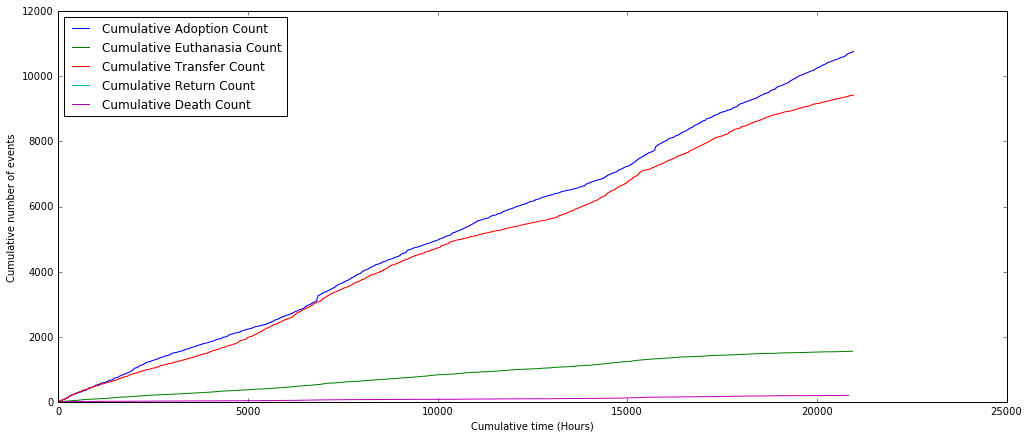

In [6]:
adoptions = training[training.OutcomeType=="Adoption"]
adoptions["CumulativeAdoptions"] = list(range(len(adoptions.index)))
euthanasias = training[training.OutcomeType=="Euthanasia"]
euthanasias["CumulativeEuthanasias"] = list(range(len(euthanasias.index)))
transfers = training[training.OutcomeType=="Transfer"]
transfers["CumulativeTransfers"] = list(range(len(transfers.index)))
returns = training[training.OutcomeType=="Return_to_Owner"]
returns["CumulativeReturns"] = list(range(len(returns)))
deaths = training[training.OutcomeType == "Died"]
deaths["CumulativeDeaths"] = list(range(len(deaths)))

plt.figure(figsize=(17,7))
plt.plot(adoptions.CumulativeTime,adoptions.CumulativeAdoptions,label="Cumulative Adoption Count")
plt.plot(euthanasias.CumulativeTime,euthanasias.CumulativeEuthanasias,label="Cumulative Euthanasia Count")
plt.plot(transfers.CumulativeTime,transfers.CumulativeTransfers,label="Cumulative Transfer Count")
plt.plot(returns.CumulativeTime,returns.CumulativeReturns,label="Cumulative Return Count")
plt.plot(deaths.CumulativeTime,deaths.CumulativeDeaths,label = "Cumulative Death Count")
plt.legend(loc=2)
plt.xlabel("Cumulative time (Hours)")
plt.ylabel("Cumulative number of events")

**There are some subtle changes in the adoption and euthanasia rates over time, but nothing drastic. **


In [7]:
dogs = training[training.AnimalType=="Dog"]
cats = training[training.AnimalType =="Cat"]

# Times and Days

**I would expect the day of the week and the time of day to influence outcomes.**


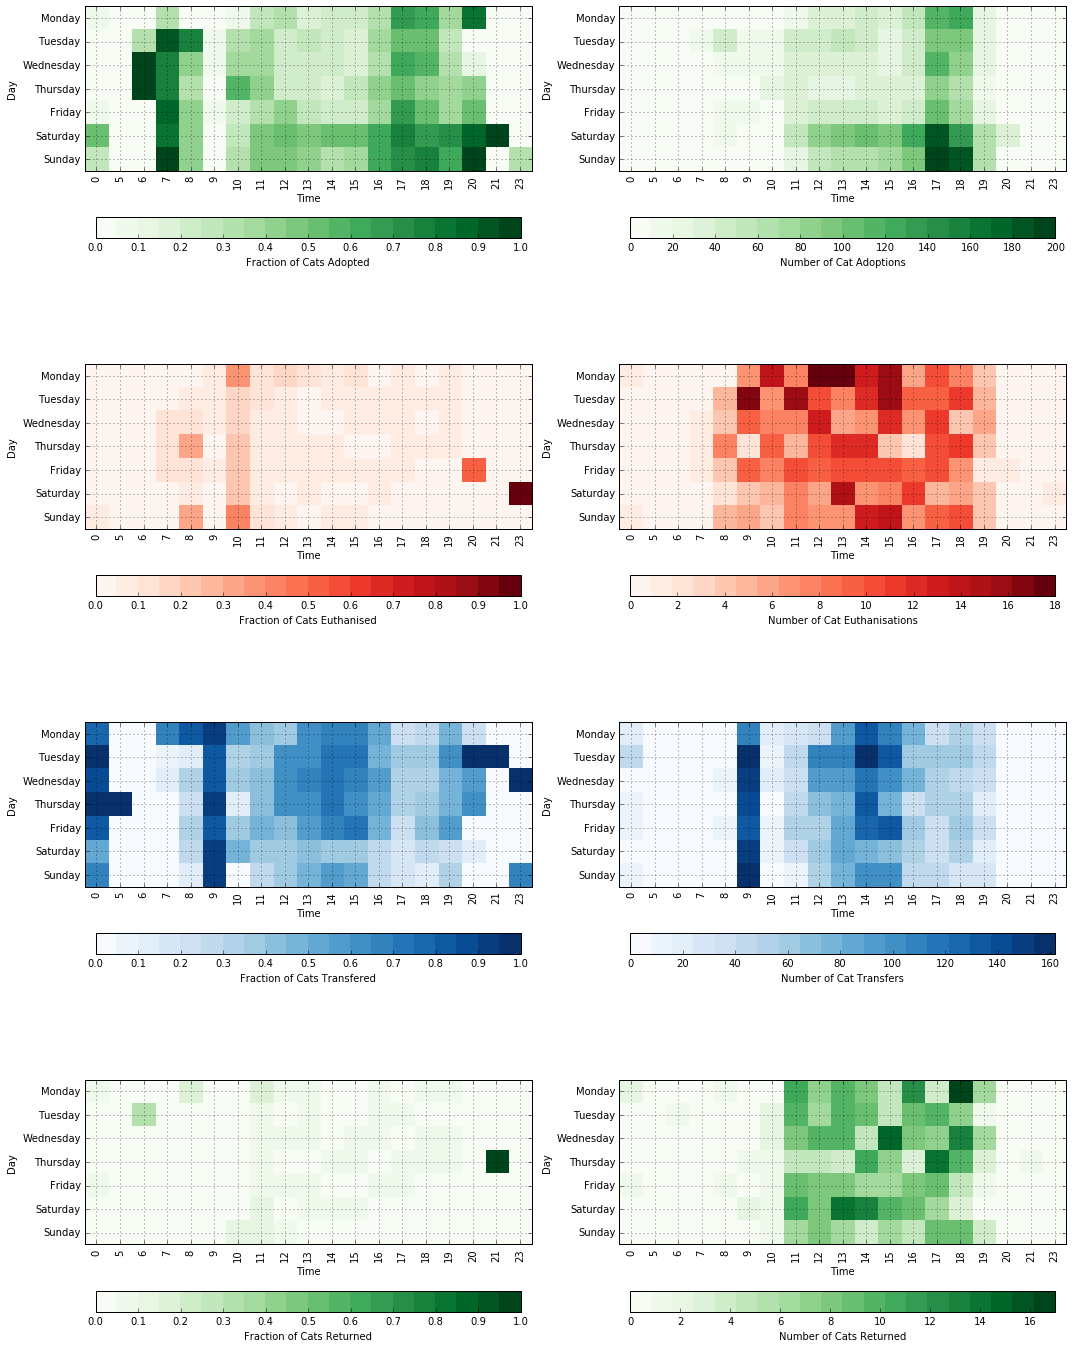

In [8]:
hour_day_breakdown = groupCountFractionals(cats,"OutcomeType",["Hour","WeekDay"])
died = hour_day_breakdown[hour_day_breakdown.OutcomeType == "Died"].sort_values(["WeekDay","Hour"])
euth = hour_day_breakdown[hour_day_breakdown.OutcomeType == "Euthanasia"].sort_values(["WeekDay","Hour"])
transfer = hour_day_breakdown[hour_day_breakdown.OutcomeType == "Transfer"].sort_values(["WeekDay","Hour"])
returned = hour_day_breakdown[hour_day_breakdown.OutcomeType == "Return_to_owner"].sort_values(["WeekDay","Hour"])
adopt = hour_day_breakdown[hour_day_breakdown.OutcomeType == "Adoption"].sort_values(["WeekDay","Hour"])

n_hours = len(died.Hour.unique())

hours = hour_day_breakdown.Hour.unique()
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

adopt_frac = adopt.Fraction.values.reshape((7,n_hours))
plt.figure(figsize=(15,22))
plt.subplot(421)
cmap = cm.get_cmap('Greens', 20) 
plt.imshow(adopt_frac, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Fraction of Cats Adopted")
plt.ylabel("Day")
plt.xlabel("Time")

adopt_count = adopt.InnerCount.values.reshape((7,n_hours))
plt.subplot(422)
cmap = cm.get_cmap('Greens', 20) 
plt.imshow(adopt_count, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Number of Cat Adoptions")
plt.tight_layout()
plt.ylabel("Day")
plt.xlabel("Time")

euth_frac = euth.Fraction.values.reshape((7,n_hours))
plt.subplot(423)
cmap = cm.get_cmap('Reds', 20) 
plt.imshow(euth_frac, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Fraction of Cats Euthanised")
plt.ylabel("Day")
plt.xlabel("Time")
euth_count = euth.InnerCount.values.reshape((7,n_hours))
plt.subplot(424)
cmap = cm.get_cmap('Reds', 20) 
plt.imshow(euth_count, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Number of Cat Euthanisations")
plt.ylabel("Day")
plt.xlabel("Time")


tran_frac = transfer.Fraction.values.reshape((7,n_hours))
plt.subplot(425)
cmap = cm.get_cmap('Blues', 20) 
plt.imshow(tran_frac, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Fraction of Cats Transfered")
plt.ylabel("Day")
plt.xlabel("Time")
tran_count = transfer.InnerCount.values.reshape((7,n_hours))
plt.subplot(426)
cmap = cm.get_cmap('Blues', 20) 
plt.imshow(tran_count, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Number of Cat Transfers")
plt.ylabel("Day")
plt.xlabel("Time")

ret_frac = returned.Fraction.values.reshape((7,n_hours))
plt.subplot(427)
cmap = cm.get_cmap('Greens', 20) 
plt.imshow(ret_frac, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Fraction of Cats Returned")
plt.ylabel("Day")
plt.xlabel("Time")
ret_count = returned.InnerCount.values.reshape((7,n_hours))
plt.subplot(428)
cmap = cm.get_cmap('Greens', 20) 
plt.imshow(ret_count, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Number of Cats Returned")
plt.ylabel("Day")
plt.xlabel("Time")

plt.tight_layout()

**People adopt cats primarily in the evenings. On the weekends, the daytime adoption rates increase, but the evening remains the busiest time. The busiest single hour of the week for cat adoptions is 5pm on Sundays**

**Transfers seem to occur at 9am every morning, with additional smaller transfers occurring at 2pm on weekdays.**

**Euthanasia occurs at all times, but there is a distinct pattern of euthanasias occurring in large numbers at 1pm on Mondays, at 3pm on Mondays and Tuesdays, at 11am on Tuesdays, and and at 1pm on Saturdays.**

**Cats are returned to their owners primarily between 11am and 7pm.**

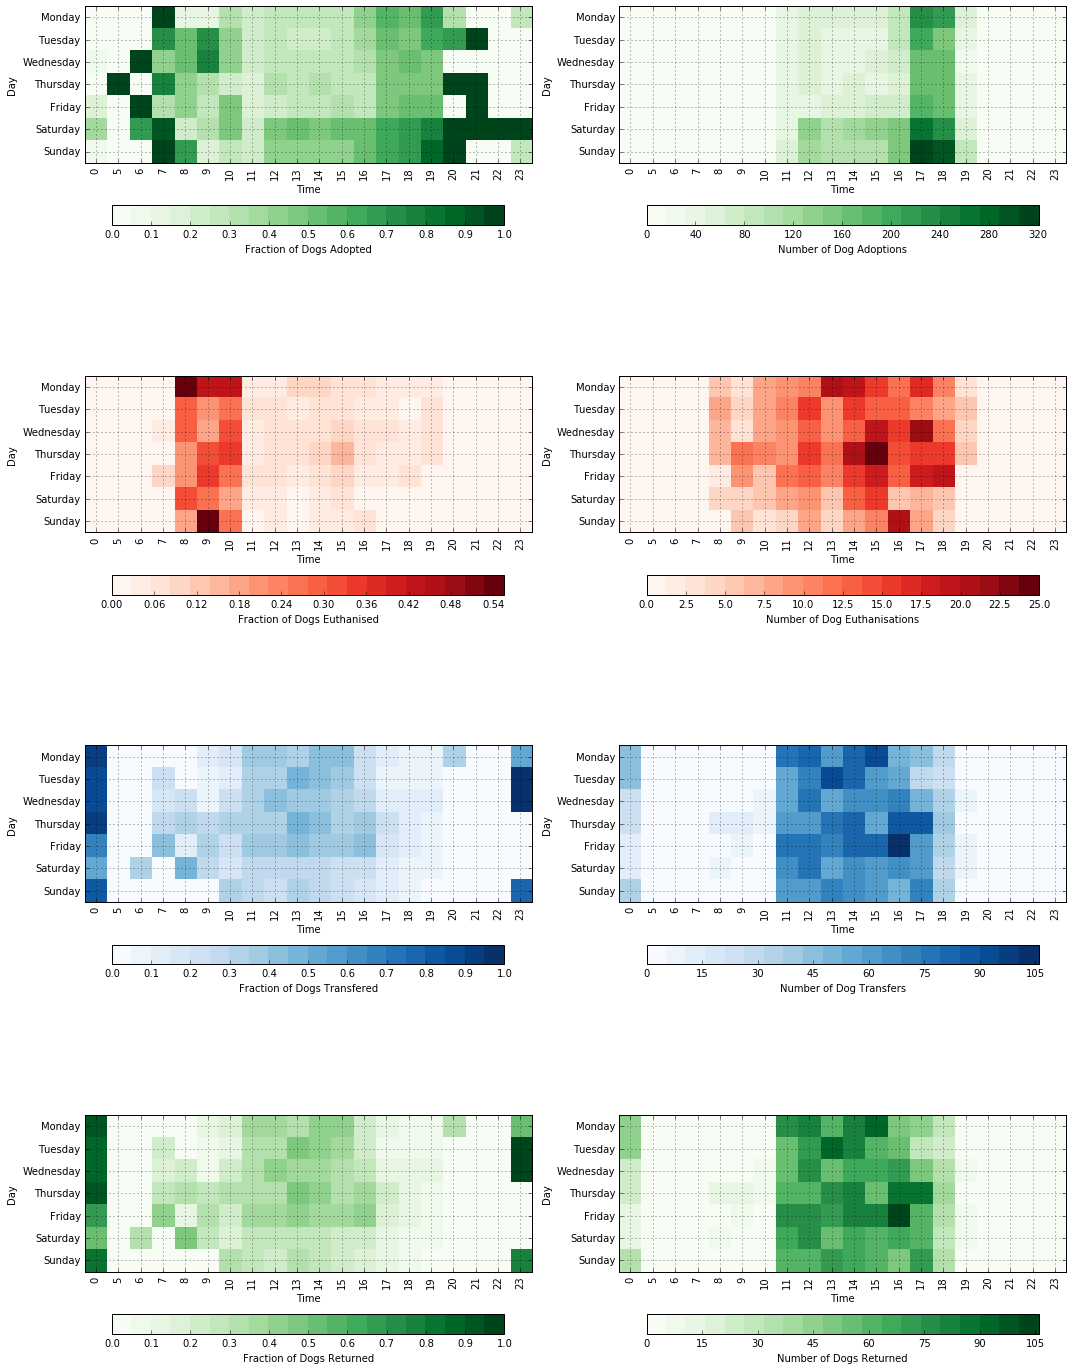

In [9]:
hour_day_breakdown = groupCountFractionals(dogs,"OutcomeType",["Hour","WeekDay"])
died = hour_day_breakdown[hour_day_breakdown.OutcomeType == "Died"].sort_values(["WeekDay","Hour"])
euth = hour_day_breakdown[hour_day_breakdown.OutcomeType == "Euthanasia"].sort_values(["WeekDay","Hour"])
transfer = hour_day_breakdown[hour_day_breakdown.OutcomeType == "Transfer"].sort_values(["WeekDay","Hour"])
returned = hour_day_breakdown[hour_day_breakdown.OutcomeType == "Return_to_owner"].sort_values(["WeekDay","Hour"])
adopt = hour_day_breakdown[hour_day_breakdown.OutcomeType == "Adoption"].sort_values(["WeekDay","Hour"])

n_hours = len(died.Hour.unique())

hours = hour_day_breakdown.Hour.unique()
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

adopt_frac = adopt.Fraction.values.reshape((7,n_hours))
plt.figure(figsize=(15,22))
plt.subplot(421)
cmap = cm.get_cmap('Greens', 20) 
plt.imshow(adopt_frac, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Fraction of Dogs Adopted")
plt.ylabel("Day")
plt.xlabel("Time")

adopt_count = adopt.InnerCount.values.reshape((7,n_hours))
plt.subplot(422)
cmap = cm.get_cmap('Greens', 20) 
plt.imshow(adopt_count, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Number of Dog Adoptions")
plt.ylabel("Day")
plt.xlabel("Time")

euth_frac = euth.Fraction.values.reshape((7,n_hours))
plt.subplot(423)
cmap = cm.get_cmap('Reds', 20) 
plt.imshow(euth_frac, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Fraction of Dogs Euthanised")
plt.ylabel("Day")
plt.xlabel("Time")
euth_count = euth.InnerCount.values.reshape((7,n_hours))
plt.subplot(424)
cmap = cm.get_cmap('Reds', 20) 
plt.imshow(euth_count, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Number of Dog Euthanisations")
plt.ylabel("Day")
plt.xlabel("Time")


tran_frac = transfer.Fraction.values.reshape((7,n_hours))
plt.subplot(425)
cmap = cm.get_cmap('Blues', 20) 
plt.imshow(tran_frac, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Fraction of Dogs Transfered")
plt.ylabel("Day")
plt.xlabel("Time")
tran_count = transfer.InnerCount.values.reshape((7,n_hours))
plt.subplot(426)
cmap = cm.get_cmap('Blues', 20) 
plt.imshow(tran_count, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Number of Dog Transfers")
plt.ylabel("Day")
plt.xlabel("Time")

ret_frac = returned.Fraction.values.reshape((7,n_hours))
plt.subplot(427)
cmap = cm.get_cmap('Greens', 20) 
plt.imshow(tran_frac, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Fraction of Dogs Returned")
plt.ylabel("Day")
plt.xlabel("Time")
ret_count = returned.InnerCount.values.reshape((7,n_hours))
plt.subplot(428)
cmap = cm.get_cmap('Greens', 20) 
plt.imshow(tran_count, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.yticks(range(len(adopt.WeekDay.unique())), days, rotation='horizontal')
plt.xticks(range(len(hours)), hours, rotation='vertical')
plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1,label = "Number of Dogs Returned")
plt.ylabel("Day")
plt.xlabel("Time")

plt.tight_layout()

**Dog adoption times and days follow the same pattern as for cats. Transfers do not appear to occur at a particular time. There are patterns of elevated return and transfer rates at 0 hours, with consistency across days between the two rates - I'm guessing this is due to the time not being entered for these cases.
There is a significantly elevated euthanasia rate first thing Monday morning, and another at 9am on Sunday morning.**

## Age

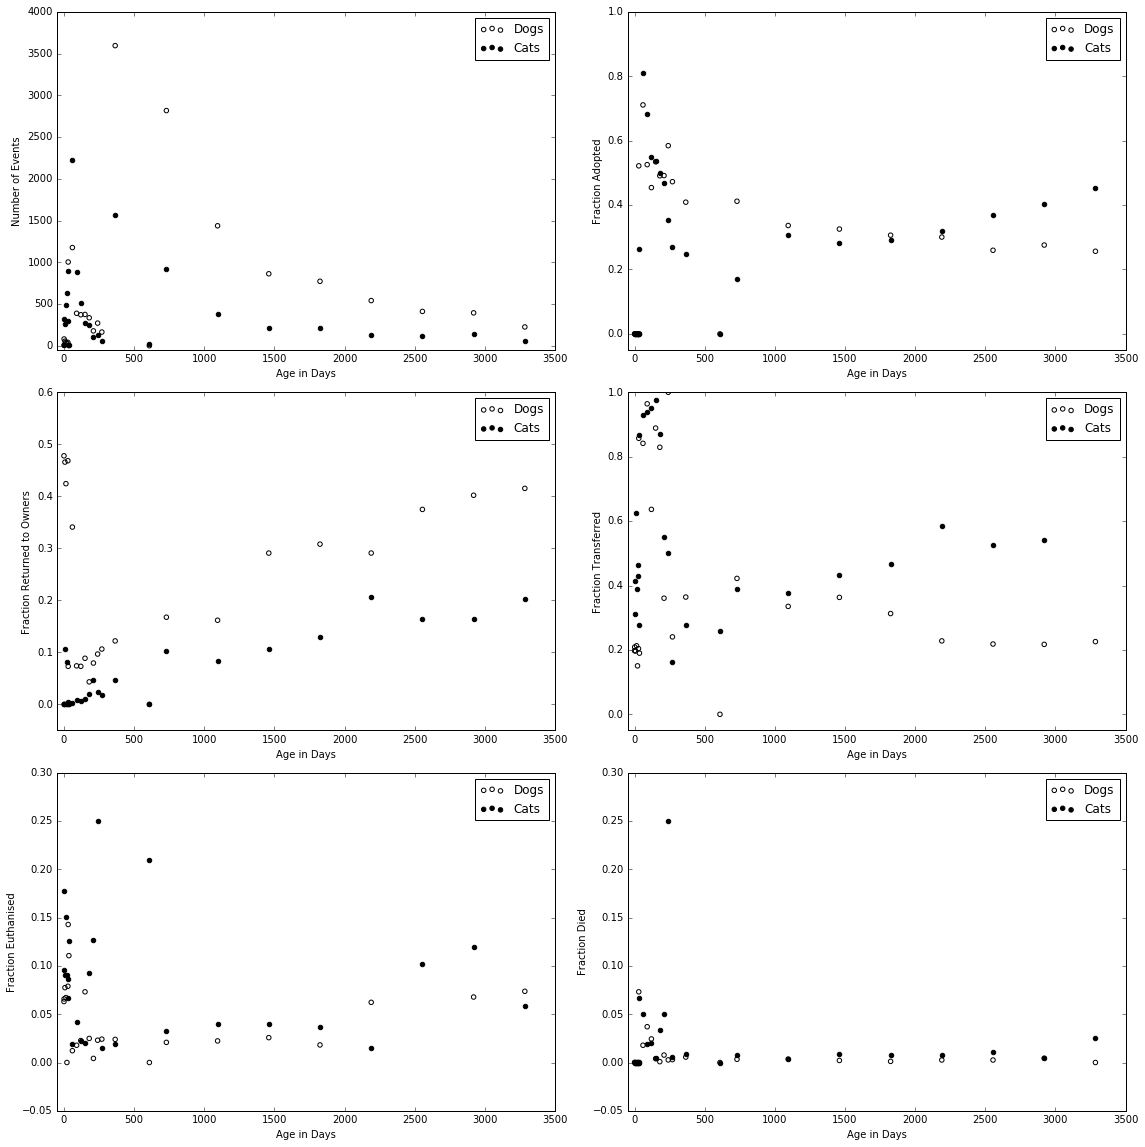

In [10]:
dog_age_outcomes = groupCountFractionals(dogs,"OutcomeType",["Age"])
dog_age_adoption = dog_age_outcomes[dog_age_outcomes.OutcomeType == "Adoption"]
dog_age_euthanasia = dog_age_outcomes[dog_age_outcomes.OutcomeType == "Euthanasia"]
dog_age_return = dog_age_outcomes[dog_age_outcomes.OutcomeType == "Return_to_owner"]
dog_age_deaths = dog_age_outcomes[dog_age_outcomes.OutcomeType == "Died"]
dog_age_transfer = dog_age_outcomes[dog_age_outcomes.OutcomeType == "Transfer"]

cat_age_outcomes = groupCountFractionals(cats,"OutcomeType",["Age"])
cat_age_adoption = cat_age_outcomes[cat_age_outcomes.OutcomeType == "Adoption"]
cat_age_euthanasia = cat_age_outcomes[cat_age_outcomes.OutcomeType == "Euthanasia"]
cat_age_return = cat_age_outcomes[cat_age_outcomes.OutcomeType == "Return_to_owner"]
cat_age_deaths = cat_age_outcomes[cat_age_outcomes.OutcomeType == "Died"]
cat_age_transfer = cat_age_outcomes[cat_age_outcomes.OutcomeType == "Transfer"]



plt.figure(figsize=(16,16))

plt.subplot(321)
plt.scatter(dog_age_adoption.Age,dog_age_adoption.OuterCount,label="Dogs",c="")
plt.scatter(cat_age_adoption.Age,cat_age_adoption.OuterCount,label="Cats",c='k')
plt.xlim(-50,3500)
plt.ylim(-50,4000)
plt.xlabel("Age in Days")
plt.ylabel("Number of Events")
plt.legend()

plt.subplot(322)
plt.scatter(dog_age_adoption.Age,dog_age_adoption.Fraction,label="Dogs",c="")
plt.scatter(cat_age_adoption.Age,cat_age_adoption.Fraction,label="Cats",c='k')
plt.xlim(-50,3500)
plt.ylim(-0.05,1)
plt.xlabel("Age in Days")
plt.ylabel("Fraction Adopted")
plt.legend()

plt.subplot(323)
plt.scatter(dog_age_adoption.Age,dog_age_return.Fraction,label="Dogs",c="")
plt.scatter(cat_age_adoption.Age,cat_age_return.Fraction,label="Cats",c='k')
plt.xlim(-50,3500)
plt.ylim(-0.05,0.6)
plt.xlabel("Age in Days")
plt.ylabel("Fraction Returned to Owners")
plt.legend()

plt.subplot(324)
plt.scatter(dog_age_adoption.Age,dog_age_transfer.Fraction,label="Dogs",c="")
plt.scatter(cat_age_adoption.Age,cat_age_transfer.Fraction,label="Cats",c='k')
plt.xlim(-50,3500)
plt.ylim(-0.05,1)
plt.xlabel("Age in Days")
plt.ylabel("Fraction Transferred")
plt.legend()

plt.subplot(325)
plt.scatter(dog_age_adoption.Age,dog_age_euthanasia.Fraction,label="Dogs",c="")
plt.scatter(cat_age_adoption.Age,cat_age_euthanasia.Fraction,label="Cats",c='k')
plt.xlim(-50,3500)
plt.ylim(-0.05,0.3)
plt.xlabel("Age in Days")
plt.ylabel("Fraction Euthanised")
plt.legend()

plt.subplot(326)
plt.scatter(dog_age_adoption.Age,dog_age_deaths.Fraction,label="Dogs",c="")
plt.scatter(cat_age_adoption.Age,cat_age_deaths.Fraction,label="Cats",c='k')
plt.xlim(-50,3500)
plt.ylim(-0.05,0.3)
plt.xlabel("Age in Days")
plt.ylabel("Fraction Died")
plt.legend()


plt.tight_layout()

**There is an overrepresentation of animals of age 0 being returned to their owners or transferred. This is most likely due to their leaving the shelter before an age could be entered into the system.
For both cats and dogs, animals in the puppy/kitten age group seem to be most popular for adoption.
**

## Names

**I think that for those animals that are named, the name they are given reflects what people think of them. Their name can therefore be used to predict their outcome, providing that there are enough animals with a particular name.**

In [11]:
named_cats = cats[cats.Named==1]
print(len(named_cats)," Named Cats",len(cats), "Total Cats")
print(len(named_cats)/len(cats) * 100, "% of cats named")
named_dogs = dogs[dogs.Named==1]
print(len(named_dogs), " Named Dogs",len(dogs), "Total Dogs")
print(len(named_dogs)/len(dogs) * 100, "% of dogs named")

6094  Named Cats 11134 Total Cats
54.7332495060176 % of cats named
12920  Named Dogs 15595 Total Dogs
82.84706636742546 % of dogs named


** Names will probably be more informative for dogs than for cats, purely due to the difference in sample size. **

# Cat Names

In [12]:
cat_train_name_ = groupCountFractionals(named_cats,"OutcomeType",["Name"])
cat_name_euth = cat_train_name_[cat_train_name_.OutcomeType == "Euthanasia"]
cat_name_adopt = cat_train_name_[cat_train_name_.OutcomeType == "Adoption"]
cat_name_return = cat_train_name_[cat_train_name_.OutcomeType == "Return_to_owner"]
cat_name_transfer = cat_train_name_[cat_train_name_.OutcomeType == "Transfer"]
cat_name_died = cat_train_name_[cat_train_name_.OutcomeType == "Died"]

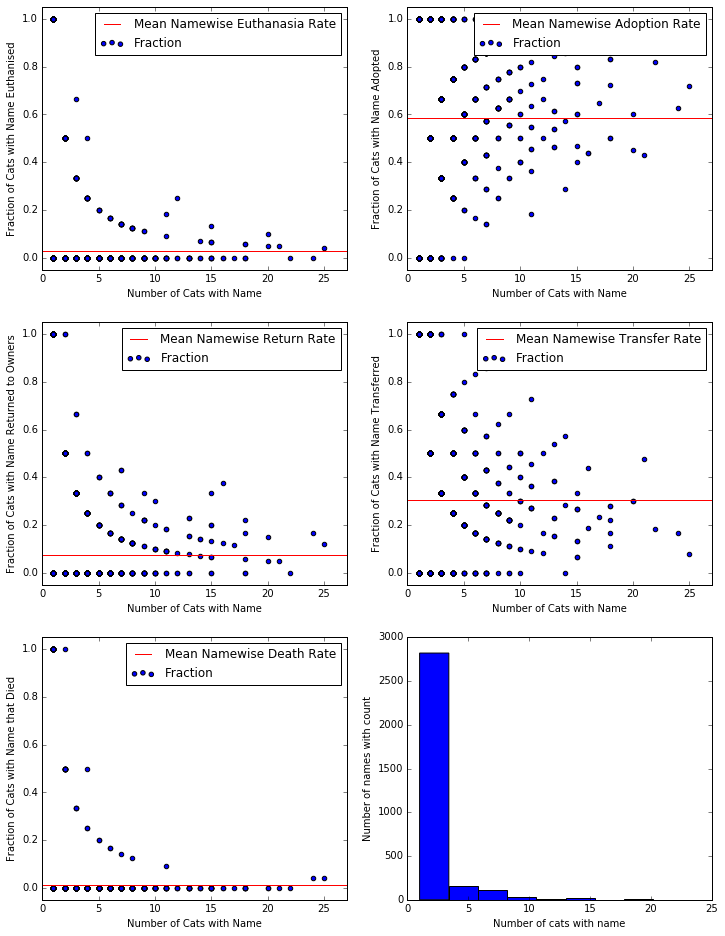

In [16]:
plt.figure(figsize=(12,16))

plt.subplot(321)
plt.scatter(cat_name_euth.OuterCount,cat_name_euth.Fraction)
plt.axhline(np.mean(cat_name_euth.Fraction),c='r',label="Mean Namewise Euthanasia Rate")
plt.xlabel("Number of Cats with Name")
plt.ylabel("Fraction of Cats with Name Euthanised")
plt.xlim(0,27)
plt.ylim(-0.05,1.05)
plt.legend()

plt.subplot(322)
plt.scatter(cat_name_adopt.OuterCount,cat_name_adopt.Fraction)
plt.xlabel("Number of Cats with Name")
plt.ylabel("Fraction of Cats with Name Adopted")
plt.axhline(np.mean(cat_name_adopt.Fraction),c='r',label="Mean Namewise Adoption Rate")
plt.xlim(0,27)
plt.ylim(-0.05,1.05)
plt.legend()

plt.subplot(323)
plt.scatter(cat_name_return.OuterCount,cat_name_return.Fraction)
plt.xlabel("Number of Cats with Name")
plt.ylabel("Fraction of Cats with Name Returned to Owners")
plt.xlim(0,27)
plt.ylim(-0.05,1.05)
plt.axhline(np.mean(cat_name_return.Fraction),c='r',label="Mean Namewise Return Rate")
plt.legend()

plt.subplot(324)
plt.scatter(cat_name_transfer.OuterCount,cat_name_transfer.Fraction)
plt.xlabel("Number of Cats with Name")
plt.ylabel("Fraction of Cats with Name Transferred")
plt.xlim(0,27)
plt.ylim(-0.05,1.05)
plt.axhline(np.mean(cat_name_transfer.Fraction),c='r',label="Mean Namewise Transfer Rate")
plt.legend()

plt.subplot(325)
plt.scatter(cat_name_died.OuterCount,cat_name_died.Fraction)
plt.xlabel("Number of Cats with Name")
plt.ylabel("Fraction of Cats with Name that Died")
plt.xlim(0,27)
plt.ylim(-0.05,1.05)
plt.axhline(np.mean(cat_name_died.Fraction),c='r',label="Mean Namewise Death Rate")
plt.legend()


plt.subplot(326)
plt.hist(cat_name_adopt.OuterCount)
plt.ylabel("Number of names with count")
plt.xlabel("Number of cats with name")

In [17]:
cat_name_sig_groups = cat_name_adopt[cat_name_adopt.OuterCount > 15].sort_values("Fraction")
cat_name_sig_groups["NotAdopted"] = cat_name_sig_groups.OuterCount - cat_name_sig_groups.InnerCount

chi2, p, ddof, expected = chi2_contingency(cat_name_sig_groups[["InnerCount","NotAdopted"]].values,correction=True)
output_template = "Chi-Squared Statistic: {}, DegreesOfFreedom: {}, p-value: {}"
print(output_template.format(chi2,ddof,p))

Chi-Squared Statistic: 24.90394296816056, DegreesOfFreedom: 13, p-value: 0.023763637842025453


**Cat names do seem to have an effect on adoption rates, but the sample size is not large enough to say which names are biased towards particular outcomes.**

## Dog Names

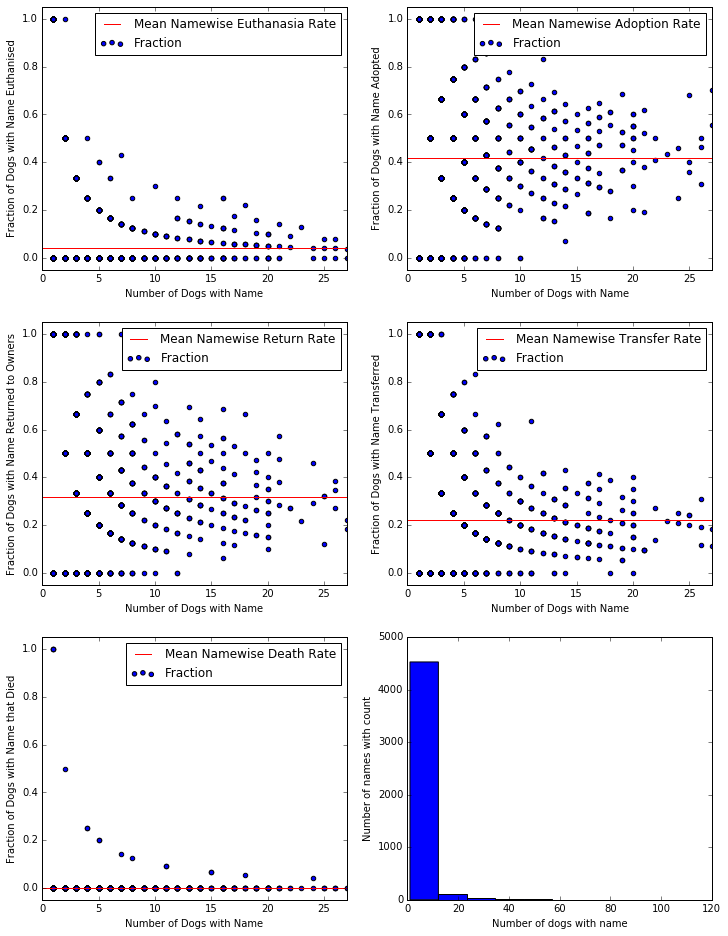

In [18]:
dog_train_name_ = groupCountFractionals(named_dogs,"OutcomeType",["Name"])
dog_name_euth = dog_train_name_[dog_train_name_.OutcomeType == "Euthanasia"]
dog_name_adopt = dog_train_name_[dog_train_name_.OutcomeType == "Adoption"]
dog_name_return = dog_train_name_[dog_train_name_.OutcomeType == "Return_to_owner"]
dog_name_transfer = dog_train_name_[dog_train_name_.OutcomeType == "Transfer"]
dog_name_died = dog_train_name_[dog_train_name_.OutcomeType == "Died"]

plt.figure(figsize=(12,16))

plt.subplot(321)
plt.scatter(dog_name_euth.OuterCount,dog_name_euth.Fraction)
plt.axhline(np.mean(dog_name_euth.Fraction),c='r',label="Mean Namewise Euthanasia Rate")
plt.xlabel("Number of Dogs with Name")
plt.ylabel("Fraction of Dogs with Name Euthanised")
plt.xlim(0,27)
plt.ylim(-0.05,1.05)
plt.legend()
plt.subplot(322)
plt.scatter(dog_name_adopt.OuterCount,dog_name_adopt.Fraction)
plt.axhline(np.mean(dog_name_adopt.Fraction),c='r',label="Mean Namewise Adoption Rate")
plt.xlabel("Number of Dogs with Name")
plt.ylabel("Fraction of Dogs with Name Adopted")
plt.xlim(0,27)
plt.ylim(-0.05,1.05)
plt.legend()
plt.subplot(323)
plt.scatter(dog_name_return.OuterCount,dog_name_return.Fraction)
plt.axhline(np.mean(dog_name_return.Fraction),c='r',label="Mean Namewise Return Rate")
plt.xlabel("Number of Dogs with Name")
plt.ylabel("Fraction of Dogs with Name Returned to Owners")
plt.xlim(0,27)
plt.ylim(-0.05,1.05)
plt.legend()
plt.subplot(324)
plt.scatter(dog_name_transfer.OuterCount,dog_name_transfer.Fraction)
plt.axhline(np.mean(dog_name_transfer.Fraction),c='r',label="Mean Namewise Transfer Rate")
plt.xlabel("Number of Dogs with Name")
plt.ylabel("Fraction of Dogs with Name Transferred")
plt.xlim(0,27)
plt.ylim(-0.05,1.05)
plt.legend()
plt.subplot(325)
plt.scatter(dog_name_died.OuterCount,dog_name_died.Fraction)
plt.axhline(np.mean(dog_name_died.Fraction),c='r',label="Mean Namewise Death Rate")
plt.xlabel("Number of Dogs with Name")
plt.ylabel("Fraction of Dogs with Name that Died")
plt.xlim(0,27)
plt.ylim(-0.05,1.05)
plt.legend()
plt.subplot(326)
plt.hist(dog_name_adopt.OuterCount)
plt.ylabel("Number of names with count")
plt.xlabel("Number of dogs with name")

In [19]:
dog_name_sig_groups = dog_name_adopt[dog_name_adopt.OuterCount > 15].sort_values("Fraction")
dog_name_sig_groups["NotAdopted"] = dog_name_sig_groups.OuterCount - dog_name_sig_groups.InnerCount

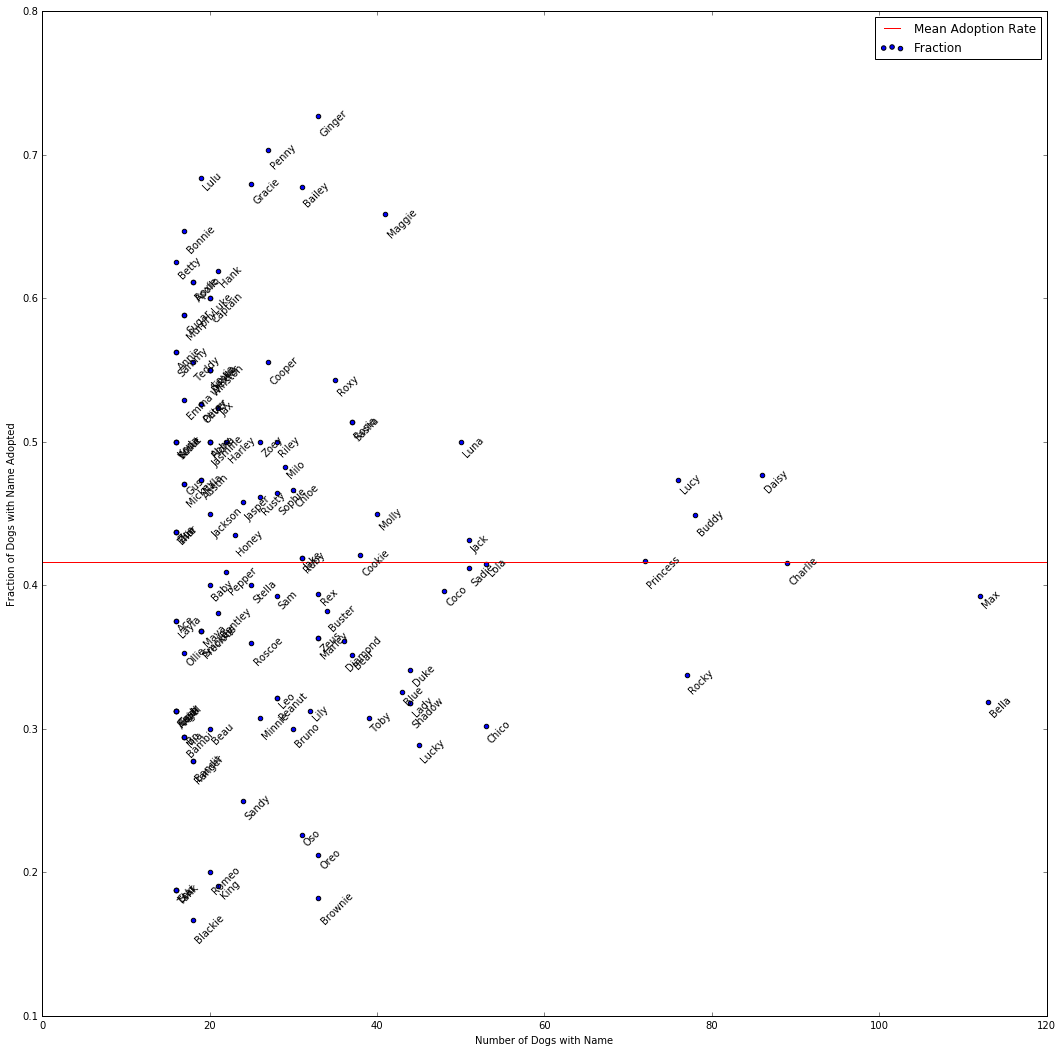

In [25]:
plt.figure(figsize=(18,18))

plt.scatter(dog_name_sig_groups.OuterCount,dog_name_sig_groups.Fraction)
plt.axhline(np.mean(dog_name_adopt.Fraction),c='r',label = "Mean Adoption Rate")
for label,x,y in zip(dog_name_sig_groups.Name,dog_name_sig_groups.OuterCount,dog_name_sig_groups.Fraction):
    plt.annotate(label,xy=(x,y),textcoords = 'offset points',xytext = (0.5, 0),rotation=45)
plt.xlabel("Number of Dogs with Name")
plt.ylabel("Fraction of Dogs with Name Adopted")
plt.legend()

In [24]:
chi2, p, ddof, expected = chi2_contingency(dog_name_sig_groups[["InnerCount","NotAdopted"]].values,correction=True)
output_template = "Chi-Squared Statistic: {}, DegreesOfFreedom: {}, p-value: {}"
print(output_template.format(chi2,ddof,p))

Chi-Squared Statistic: 196.2181937034669, DegreesOfFreedom: 119, p-value: 1.0731722727431335e-05


**Dog names do have a significant effect on adoption rates**

In [27]:
#Sanity check - Dog names should not significantly influence deaths.
dog_name_sig_groups = dog_name_died[dog_name_died.OuterCount > 15].sort_values("Fraction")
dog_name_sig_groups["DidNotDie"] = dog_name_sig_groups.OuterCount - dog_name_sig_groups.InnerCount

chi2, p, ddof, expected = chi2_contingency(dog_name_sig_groups[["InnerCount","DidNotDie"]].values,correction=True)
output_template = "Chi-Squared Statistic: {}, DegreesOfFreedom: {}, p-value: {}"
print(output_template.format(chi2,ddof,p))


Chi-Squared Statistic: 88.79847284234032, DegreesOfFreedom: 119, p-value: 0.982525984889103




## Cat Breeds

In [28]:
breeds = cats.Breed.unique()
len(breeds)

60

In [29]:
def splitBreed(breed):
    if "Mix" in breed:
        component_a = breed[:-4]
        component_b = "Unknown"
    elif "/" in breed:
        components = breed.split("/")
        component_a = components[0]
        component_b = components[1]
    else:
        component_a = breed
        component_b = breed
    return [component_a,component_b]

cats["breed_components"] = cats.Breed.apply(splitBreed)
cats["BreedComponentA"] = cats.breed_components.apply(lambda x:x[0])
cats["BreedComponentB"] = cats.breed_components.apply(lambda x:x[1])


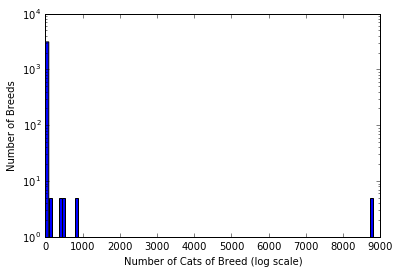

In [30]:
breed_outcomes = groupCountFractionals(cats,"OutcomeType",["BreedComponentA","BreedComponentB"])
counts = breed_outcomes.OuterCount
plt.hist(counts,bins=100)
plt.yscale("log")
plt.xlabel("Number of Cats of Breed (log scale)")
plt.ylabel("Number of Breeds")
adoptions = breed_outcomes[breed_outcomes.OutcomeType == "Adoption"]

**The more common breeds of cats outnumber the rarer ones by more than 1000-fold.**

In [31]:
len(adoptions.BreedComponentA.unique()),len(adoptions.BreedComponentB.unique())

(33, 19)

In [32]:
adoptions = breed_outcomes[breed_outcomes.OutcomeType == "Adoption"]
adoptions = adoptions.sort_values(["BreedComponentA","BreedComponentB"],ascending=False)
adoption_array = adoptions.Fraction.values.reshape(33,19)

breed_count_array = adoptions.OuterCount.values.reshape(33,19)
a_components = adoptions.BreedComponentA.unique()
b_components = adoptions.BreedComponentB.unique()

returns = breed_outcomes[breed_outcomes.OutcomeType == "Return_to_owner"]
returns = returns.sort_values(["BreedComponentA","BreedComponentB"],ascending=False)
return_array = returns.Fraction.values.reshape(33,19)

euths = breed_outcomes[breed_outcomes.OutcomeType == "Euthanasia"]
euths = returns.sort_values(["BreedComponentA","BreedComponentB"],ascending=False)
euth_array = returns.Fraction.values.reshape(33,19)

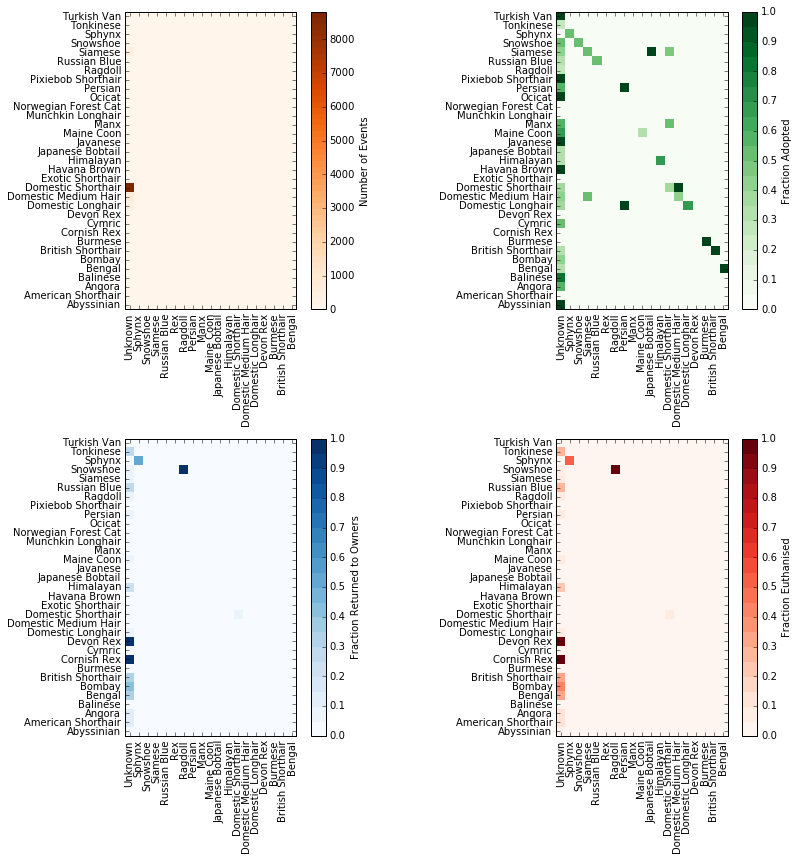

In [33]:
plt.figure(figsize=(12,12))
plt.subplot(221)
cmap = cm.get_cmap('Oranges', 50)
plt.imshow(breed_count_array, interpolation="nearest",cmap=cmap)
plt.xticks(range(len(b_components)), b_components, rotation='vertical')
plt.yticks(range(len(a_components)), a_components, rotation='horizontal')
plt.colorbar(fraction=0.046, pad=0.04,label = "Number of Events")

plt.subplot(222)
cmap = cm.get_cmap('Greens', 20)
plt.imshow(adoption_array, interpolation="nearest",cmap=cmap)
plt.xticks(range(len(b_components)), b_components, rotation='vertical')
plt.yticks(range(len(a_components)), a_components, rotation='horizontal')
plt.colorbar(fraction=0.046, pad=0.04,label = "Fraction Adopted")

plt.subplot(223)
cmap = cm.get_cmap('Blues', 20)
plt.imshow(return_array, interpolation="nearest",cmap=cmap)
plt.xticks(range(len(b_components)), b_components, rotation='vertical')
plt.yticks(range(len(a_components)), a_components, rotation='horizontal')
plt.colorbar(fraction=0.046, pad=0.04,label = "Fraction Returned to Owners")

plt.subplot(224)
cmap = cm.get_cmap('Reds', 20)
plt.imshow(euth_array, interpolation="nearest",cmap=cmap)
plt.xticks(range(len(b_components)), b_components, rotation='vertical')
plt.yticks(range(len(a_components)), a_components, rotation='horizontal')
plt.colorbar(fraction=0.046, pad=0.04,label = "Fraction Euthanised")

plt.tight_layout()

**These data suggest that breed does play a role in determining outcomes for cats, but the majority of cats are mixed breeds, meaning that it might be more informative to condition on just a single breed component.**

In [46]:
cat_componentA = groupCountFractionals(cats,"OutcomeType",["BreedComponentA"])
adoption = cat_componentA[cat_componentA.OutcomeType == "Adoption"]
returns = cat_componentA[cat_componentA.OutcomeType == "Return_to_owner"]
euthanasia = cat_componentA[cat_componentA.OutcomeType == "Euthanasia"]

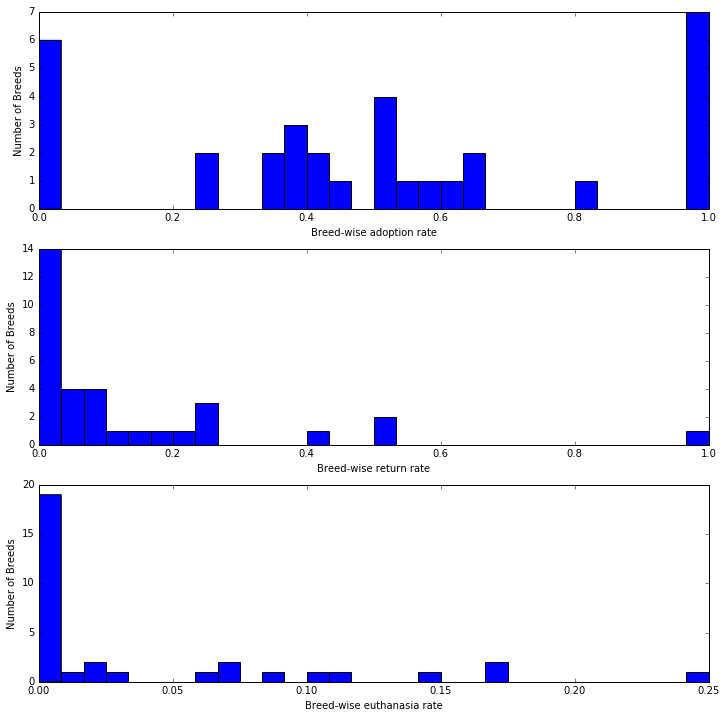

In [47]:
plt.figure(figsize=(12,12))
plt.subplot(311)
plt.hist(adoption.Fraction,bins=30)
plt.ylabel("Number of Breeds")
plt.xlabel("Breed-wise adoption rate")

plt.subplot(312)
plt.hist(returns.Fraction,bins=30)
plt.ylabel("Number of Breeds")
plt.xlabel("Breed-wise return rate")

plt.subplot(313)
plt.hist(euthanasia.Fraction,bins=30)
plt.ylabel("Number of Breeds")
plt.xlabel("Breed-wise euthanasia rate")

In [34]:
cats["CommonBreed"] = [1 if x == "Domestic Shorthair" else 0 for x in cats.BreedComponentA]

In [35]:
groupCountFractionals(cats,"OutcomeType",["CommonBreed"])

,CommonBreed,Fraction,InnerCount,OutcomeType,OuterCount
0,0,0.433824,944,Adoption,2176
1,0,0.014246,31,Died,2176
2,0,0.075827,165,Euthanasia,2176
3,0,0.062500,136,Return_to_owner,2176
4,0,0.413603,900,Transfer,2176
5,1,0.371511,3328,Adoption,8958
6,1,0.012949,116,Died,8958
7,1,0.060839,545,Euthanasia,8958
8,1,0.040634,364,Return_to_owner,8958
9,1,0.514066,4605,Transfer,8958


In [91]:
gc = groupCountFractionals(cats,"OutcomeType",["CommonBreed"])
gc_a = gc[gc.OutcomeType == "Adoption"]
gc_r = gc[gc.OutcomeType == "Return_to_owner"]

In [92]:
gc_a

,CommonBreed,Fraction,InnerCount,OutcomeType,OuterCount
0,0,0.433824,944,Adoption,2176
5,1,0.371511,3328,Adoption,8958


In [95]:
from scipy.stats import chi2_contingency

In [109]:
chi2, p, ddof, expected = chi2_contingency(np.array([[944,2176-944],[3328,8958-3328]]),correction=True)
output_template = "Chi-Squared Statistic: {}, DegreesOfFreedom: {}, p-value: {}"
print(output_template.format(chi2,ddof,p))

Chi-Squared Statistic: 28.483467741475295, DegreesOfFreedom: 1, p-value: 9.450198226857078e-08


In [110]:
gc_r

,CommonBreed,Fraction,InnerCount,OutcomeType,OuterCount
3,0,0.062500,136,Return_to_owner,2176
8,1,0.040634,364,Return_to_owner,8958


In [111]:
chi2, p, ddof, expected = chi2_contingency(np.array([[136,2176-136],[364,8958-364]]),correction=True)
output_template = "Chi-Squared Statistic: {}, DegreesOfFreedom: {}, p-value: {}"
print(output_template.format(chi2,ddof,p))

Chi-Squared Statistic: 19.00950674481047, DegreesOfFreedom: 1, p-value: 1.3006880062231805e-05


**Cat breeds do have an effect on outcome, with Domestic Shorthairs being significantly less likely to be adopted or returned to an owner than other breed types.**

# Dog Breeds

**There are too many dog breeds to process them directly. Fortunately, there is a wikipedia page that lists dog breeds and their kennel club classifications.**

In [25]:
wiki_url = "https://en.wikipedia.org/wiki/List_of_dog_breeds"
q = Request(wiki_url)
q.add_header('User-Agent', 'Mozilla/5.0')
req = urlopen(q)
soup = BeautifulSoup(req,"lxml")
table = soup.find("table", { "class" : "wikitable sortable" })
breed = []
fci = []
akc = []
ankc = []
ckc = []
tkc =[]
nzkc = []
ukc = []
for row in table.findAll("tr"):
    cells = row.findAll("td")
    #For each "tr", assign each "td" to a variable.
    if len(cells) == 10:
        breed.append(cells[0].find(text=True))
        fci.append(cells[2].find(text=True))
        akc.append(cells[3].find(text=True))
        ankc.append(cells[4].find(text=True))
        ckc.append(cells[5].find(text=True))
        tkc.append(cells[6].find(text=True))
        nzkc.append(cells[7].find(text=True))
        ukc.append(cells[8].find(text=True))
kennel_classifications = pandas.DataFrame({
    "Breed":breed,
    "FCI":fci,
    "AKC":akc,
    "ANKC":ankc,
    "CKC":ckc,
    "TKC":tkc,
    "NZKC":nzkc,
    "UKC":ukc
})

FCI_types = kennel_classifications.FCI
fci_groups = FCI_types.str.extract("(Group.[0-9]+)")
fci_groups_sections = FCI_types.str.extract("(Group.[0-9]+.Section.[0-9]+)")
kennel_classifications["FCI_Group"] = fci_groups
kennel_classifications["FCI_Section"] = fci_groups_sections

distinct_fci_groups = fci_groups.dropna().unique()
distinct_fci_sections = fci_groups_sections.dropna().unique()

kennel_classifications = kennel_classifications.fillna("Unknown")


In [26]:
kennel_classifications.UKC.unique()

array(['Companion Dog', 'Sighthound and Pariah', 'Unknown', 'Guardian Dog',
       'Terrier', 'Northern Breed', 'Scenthound', 'Extinct', 'Gun Dog',
       'Herding Dog', 'Sight hound', 'Sight hound and Bear hound',
       'Scenthound Group', 'Northern Breeds', 'Not recognised', 'Guardian',
       'Scenthound Dog', 'Companion Dog, Gun Dog', 'Terriers',
       'Guarding Dog'], dtype=object)

In [27]:
kennel_classifications.loc[kennel_classifications.UKC == "Guardian","UKC"] = "Guardian Dog"
kennel_classifications.loc[kennel_classifications.UKC == "Guarding Dog","UKC"] = "Guard"
kennel_classifications.loc[kennel_classifications.UKC == "Terriers","UKC"] = "Terrier"
kennel_classifications.loc[kennel_classifications.UKC == "Not recognised","UKC"] = "Unknown"
kennel_classifications.loc[kennel_classifications.UKC == "Scenthound Group","UKC"] = "Scenthound Dog"
kennel_classifications.loc[kennel_classifications.UKC == "Sighthound and Pariah","UKC"] = "Sighthound"
kennel_classifications.loc[kennel_classifications.UKC == "Sight hound and Bear hound","UKC"] = "Sighthound"
kennel_classifications.loc[kennel_classifications.UKC == "Scenthound Dog","UKC"] = "Scenthound"

kennel_classifications.loc[kennel_classifications.UKC == "Sight hound","UKC"] = "Sighthound"
kennel_classifications.loc[kennel_classifications.UKC == "Northern Breeds","UKC"] = "Northern Breed"
kennel_classifications.loc[kennel_classifications.TKC == "Toys","TKC"] = "Toy Group"
kennel_classifications.loc[kennel_classifications.TKC == "Toy","TKC"] = "Toy Group"
kennel_classifications.loc[kennel_classifications.TKC == "Terriers","TKC"] = "Terrier"
kennel_classifications.loc[kennel_classifications.TKC == "Gun dog","TKC"] = "Gundog"



In [28]:
training.loc[training.Breed == "Pit Bull","Breed"] = "American Pit Bull Terrier"
dogs.loc[dogs.Breed == "Pit Bull","Breed"] = "American Pit Bull Terrier"

In [29]:
def dogBreedToType(breed,kennel="TKC"):
    if "Mix" in breed:
        types = ["Unknown"]
        breed = breed[:-4]
    else:
        types = []
    breeds = breed.split("/")
    for b in breeds:
        b = re.sub("Miniature","",b)
        b = re.sub("Cardigan","",b)
        close_matches = difflib.get_close_matches(b, kennel_classifications.Breed)
        if len(close_matches) == 0:
                types.append("Unknown")
        else:
            close_match = close_matches[0]
            match_breed_type = kennel_classifications[kennel_classifications.Breed == close_match][kennel].values[0]
            types.append(match_breed_type)
    
    return types



In [30]:
def splitType(ukc):
    if len(ukc) == 1:
        return pandas.Series({"Type1":ukc[0],"Type2":ukc[0]})
    else:
        return pandas.Series({"Type1":ukc[0],"Type2":ukc[1]})

In [31]:
dog_types = dogs.Breed.apply(dogBreedToType)  
dogs["UKC"] = dog_types
ukc_cols = dogs["UKC"].apply(splitType)
dogs_with_ukc = dogs.join(ukc_cols)
dogs_with_ukc.Type1 = dogs_with_ukc.Type1.fillna("Unknown")
dogs_with_ukc.Type2 = dogs_with_ukc.Type2.fillna("Unknown")

In [32]:
dogs_with_ukc = dogs_with_ukc.sort_values(["Type1","Type2"])
Type1s = dogs_with_ukc.Type1.unique()
Type2s = dogs_with_ukc.Type1.unique()
d1 = len(Type1s)
d2 = len(Type2s)
d1,d2

(9, 9)

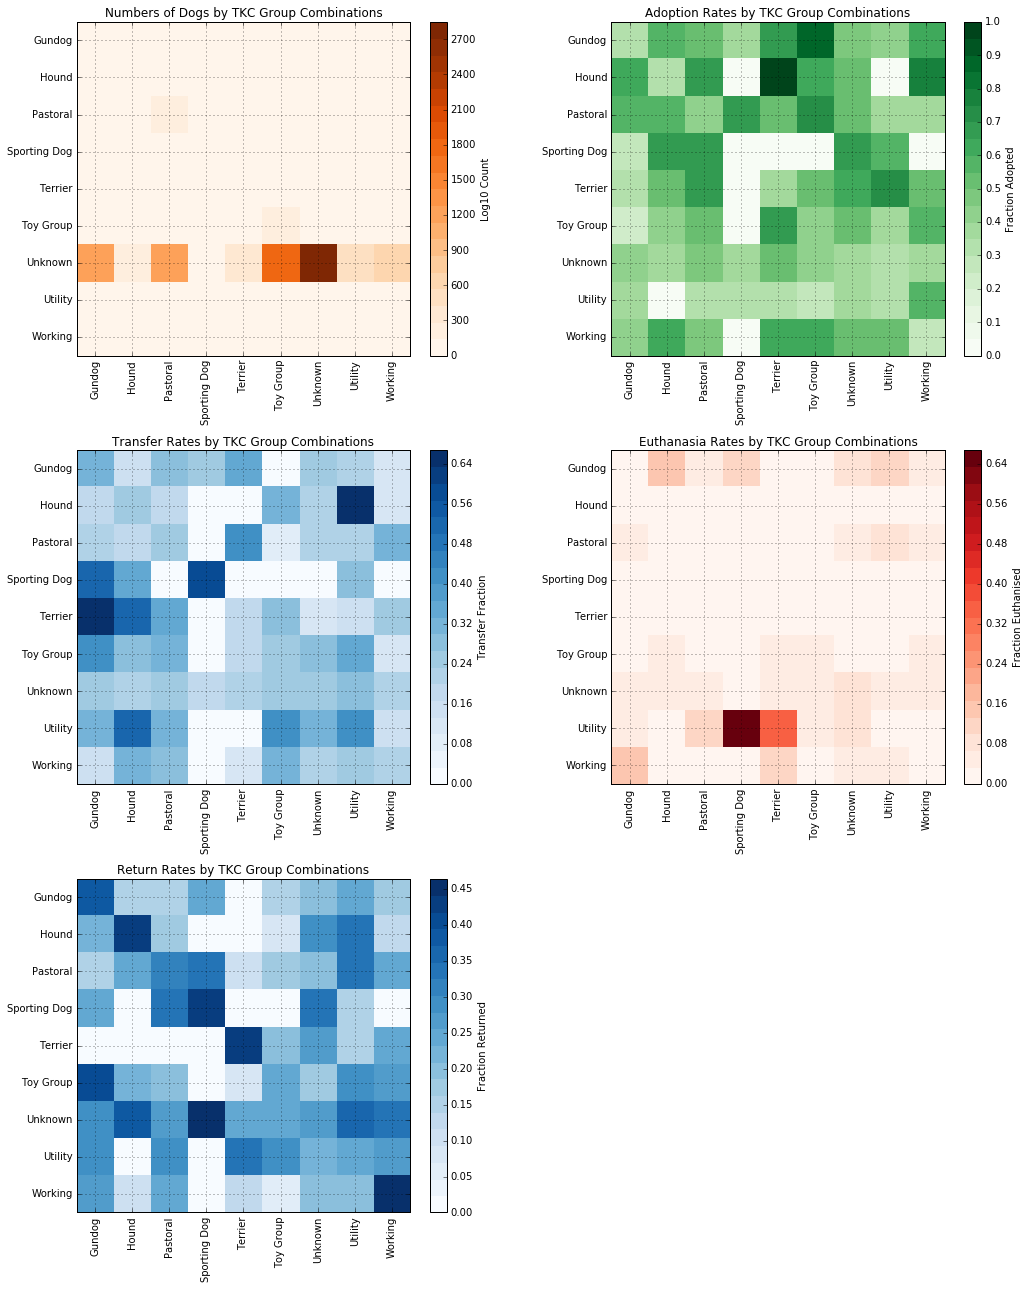

In [33]:
pairwise_rates = groupCountFractionals(dogs_with_ukc,"OutcomeType",["Type1","Type2"])
pairwise_adoption = pairwise_rates[pairwise_rates.OutcomeType == "Adoption"]
pairwise_adoption = pairwise_adoption.sort_values(["Type1","Type2"])
adoption_array = pairwise_adoption.Fraction.values.reshape((d1,d2))
adoption_count_array = (pairwise_adoption.OuterCount.values)
adoption_count_array[np.isinf(adoption_count_array)] = 0
adoption_count_array[np.isnan(adoption_count_array)] = 0
adoption_count_array = adoption_count_array.reshape((d1,d2))

pairwise_transfer = pairwise_rates[pairwise_rates.OutcomeType == "Transfer"].sort_values(["Type1","Type2"])
pairwise_transfer = pairwise_transfer.sort_values(["Type1","Type2"])
transfer_array = pairwise_transfer.Fraction.values.reshape((d1,d2))


pairwise_euthanasia = pairwise_rates[pairwise_rates.OutcomeType == "Euthanasia"].sort_values(["Type1","Type2"])
pairwise_euthanasia = pairwise_euthanasia.sort_values(["Type1","Type2"])
euthanasia_array = pairwise_euthanasia.Fraction.values.reshape((d1,d2))



pairwise_return = pairwise_rates[pairwise_rates.OutcomeType == "Return_to_owner"].sort_values(["Type1","Type2"])
pairwise_return = pairwise_return.sort_values(["Type1","Type2"])
return_array = pairwise_return.Fraction.values.reshape((d1,d2))


plt.figure(figsize=(15,18))


plt.subplot(321)
plt.title("Numbers of Dogs by TKC Group Combinations")
cmap = cm.get_cmap('Oranges', 20)
plt.imshow(adoption_count_array, interpolation="nearest",cmap=cmap)
plt.grid(True)
plt.xticks(range(len(Type1s)), Type1s, rotation='vertical')
plt.yticks(range(len(Type1s)), Type1s, rotation='horizontal')
plt.colorbar(fraction=0.046, pad=0.04,label = "Log10 Count")
plt.tight_layout()



plt.subplot(322)
cmap = cm.get_cmap('Greens', 20) 
plt.imshow(adoption_array, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.xticks(range(len(Type1s)), Type1s, rotation='vertical')
plt.yticks(range(len(Type1s)), Type1s, rotation='horizontal')
plt.colorbar(fraction=0.046, pad=0.04,label = "Fraction Adopted")
plt.title("Adoption Rates by TKC Group Combinations")

plt.subplot(323)
plt.title("Transfer Rates by TKC Group Combinations")
cmap = cm.get_cmap('Blues', 20)
plt.imshow(transfer_array, interpolation="nearest",cmap=cmap)
plt.grid(True)
plt.xticks(range(len(Type1s)), Type1s, rotation='vertical')
plt.yticks(range(len(Type1s)), Type1s, rotation='horizontal')
plt.colorbar(fraction=0.046, pad=0.04,label = "Transfer Fraction")

plt.subplot(324)
cmap = cm.get_cmap('Reds', 20) 
plt.imshow(euthanasia_array, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.xticks(range(len(Type1s)), Type1s, rotation='vertical')
plt.yticks(range(len(Type1s)), Type1s, rotation='horizontal')
plt.colorbar(fraction=0.046, pad=0.04,label = "Fraction Euthanised")
plt.title("Euthanasia Rates by TKC Group Combinations")

plt.subplot(325)
cmap = cm.get_cmap('Blues', 20) 
plt.imshow(return_array, interpolation="nearest", cmap=cmap)
plt.grid(True)
plt.xticks(range(len(Type1s)), Type1s, rotation='vertical')
plt.yticks(range(len(Type1s)), Type1s, rotation='horizontal')
plt.colorbar(fraction=0.046, pad=0.04,label = "Fraction Returned")
plt.title("Return Rates by TKC Group Combinations")





plt.tight_layout()

**Almost all of the dogs have at least one unknown type component. I am going to try conditioning on a single component (Type2) ignoring Type1 which is almost entirely composed of 'Unknown' values. **

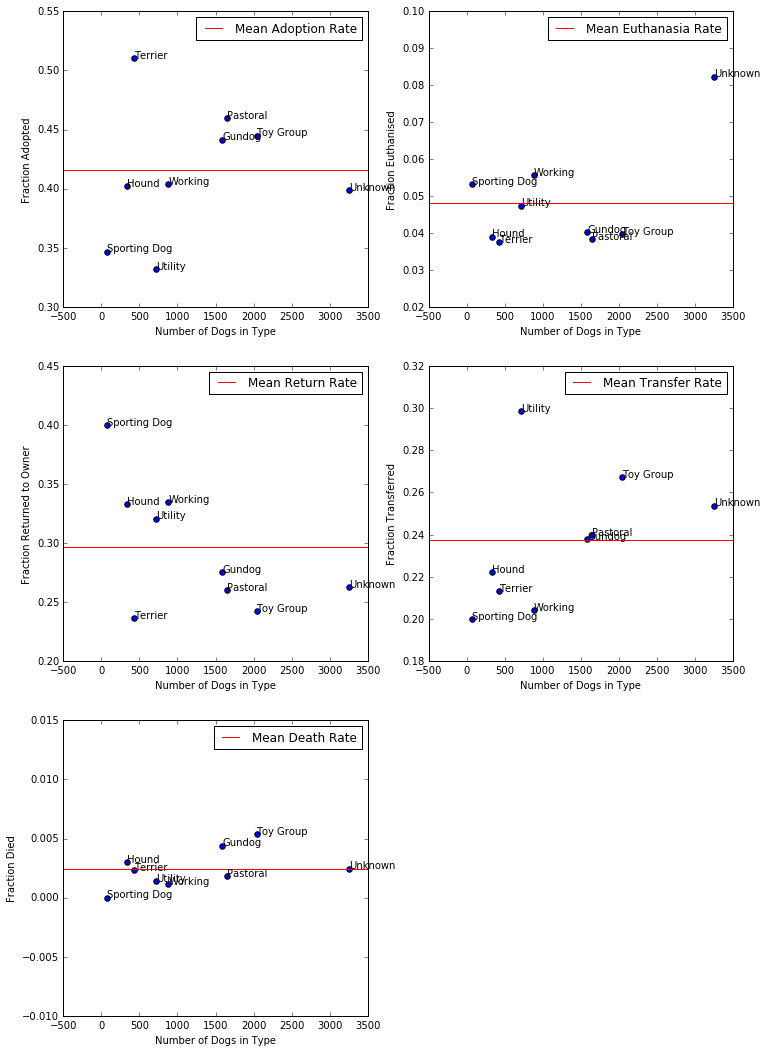

In [34]:
types = dogs_with_ukc.sort_values("Type2").Type2.unique()
x_vals = range(len(types))
type_outcomes = groupCountFractionals(dogs_with_ukc,"OutcomeType",["Type2"])
type_adoption = type_outcomes[type_outcomes.OutcomeType == "Adoption"]
type_adoption = type_adoption.sort_values(["Type2"])

type_counts = type_adoption.OuterCount.values
                                           
type_transfer = type_outcomes[type_outcomes.OutcomeType == "Transfer"].sort_values(["Type2"])

type_euthanasia = type_outcomes[type_outcomes.OutcomeType == "Euthanasia"].sort_values(["Type2"])


type_return = type_outcomes[type_outcomes.OutcomeType == "Return_to_owner"].sort_values(["Type2"])

type_died = type_outcomes[type_outcomes.OutcomeType == "Died"].sort_values(["Type2"])
                                           
plt.figure(figsize=(12,18))                                           
plt.subplot(321)
plt.scatter(type_adoption.OuterCount.values,type_adoption.Fraction.values,s=30)
for i, txt in enumerate(types):
    plt.annotate(txt, (type_adoption.OuterCount.values[i],type_adoption.Fraction.values[i]))
mean_adoption = np.mean(type_adoption.Fraction)
plt.axhline(mean_adoption,c='r',label = "Mean Adoption Rate")
plt.legend()
plt.ylabel("Fraction Adopted")
plt.xlabel("Number of Dogs in Type")

plt.subplot(322)
plt.scatter(type_euthanasia.OuterCount.values,type_euthanasia.Fraction.values,s=30)
for i, txt in enumerate(types):
    plt.annotate(txt, (type_euthanasia.OuterCount.values[i],type_euthanasia.Fraction.values[i]))
mean_euthanasia = np.mean(type_euthanasia.Fraction)
plt.axhline(mean_euthanasia,c='r',label = "Mean Euthanasia Rate")
plt.legend()
plt.ylabel("Fraction Euthanised")
plt.xlabel("Number of Dogs in Type")

plt.subplot(323)
plt.scatter(type_return.OuterCount.values,type_return.Fraction.values,s=30)
for i, txt in enumerate(types):
    plt.annotate(txt, (type_return.OuterCount.values[i],type_return.Fraction.values[i]))
mean_return = np.mean(type_return.Fraction)
plt.axhline(mean_return,c='r',label = "Mean Return Rate")
plt.legend()
plt.ylabel("Fraction Returned to Owner")
plt.xlabel("Number of Dogs in Type")



plt.subplot(324)
plt.scatter(type_transfer.OuterCount.values,type_transfer.Fraction.values,s=30)
for i, txt in enumerate(types):
    plt.annotate(txt, (type_transfer.OuterCount.values[i],type_transfer.Fraction.values[i]))
mean_transfer = np.mean(type_transfer.Fraction)
plt.axhline(mean_transfer,c='r',label = "Mean Transfer Rate")
plt.legend()
plt.ylabel("Fraction Transferred")
plt.xlabel("Number of Dogs in Type")

plt.subplot(325)
plt.scatter(type_died.OuterCount.values,type_died.Fraction.values,s=30)
for i, txt in enumerate(types):
    plt.annotate(txt, (type_died.OuterCount.values[i],type_died.Fraction.values[i]))
mean_died = np.mean(type_died.Fraction)
plt.axhline(mean_died,c='r',label = "Mean Death Rate")
plt.legend()
plt.ylabel("Fraction Died")
plt.xlabel("Number of Dogs in Type")



**Working dogs and dogs of completely unknown types are more likely to be euthanised.**

**Terriers,Gundogs, Pastoral, and Toy Dogs are more likely to be adopted.**

**Sporting, Hound, and Working dogs are more likely to be returned to their owners (Maybe these dogs are more likely to get lost in the first place if they are being used for hunting etc?).**

**Utility and Toy dogs have the highest transfer rates.**

**While considering dog breeds, I also want to try and capture the subjective perceptions that people my have about certain breeds. I'm going to make a list of dog breeds that make me uncomfortable**


In [35]:
scary_breeds = ["American Bulldog","Rottweiler","Mastiff","Pit Bull","Staffordshire","Dogo Argentino","Boxer","Tosa","Chow"]
def isScary(breed):
    close_matches = []
    breeds = breed.split("/")
    for b in breeds:
        close_matches.extend(difflib.get_close_matches(breed,scary_breeds))
    if len(close_matches) > 0:
        return 1
    else:
        return 0

In [36]:
dogs_with_ukc["IsScary"] = dogs_with_ukc.Breed.apply(isScary)

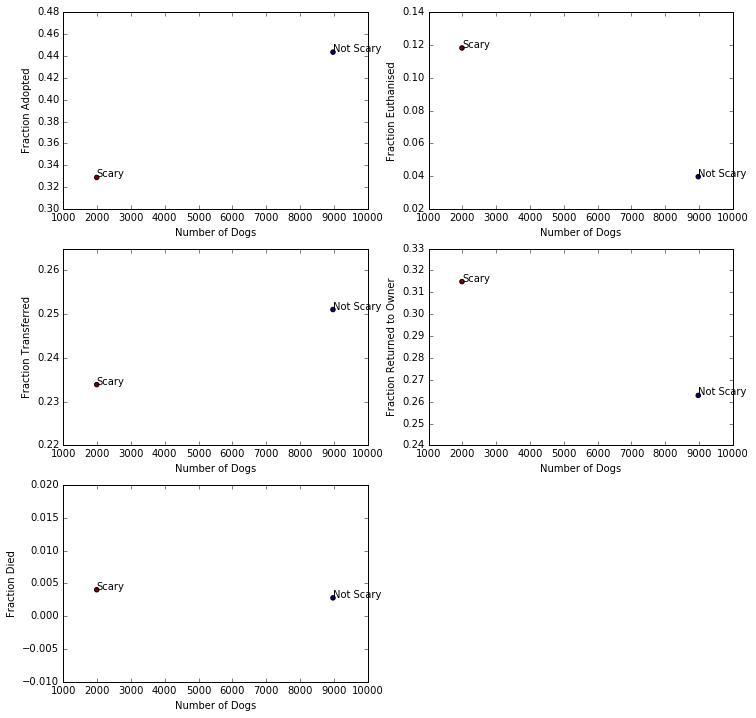

In [37]:
scary_outcomes = groupCountFractionals(dogs_with_ukc,"OutcomeType",["IsScary"])
scary_adopt = scary_outcomes[scary_outcomes.OutcomeType == "Adoption"]
scary_euth = scary_outcomes[scary_outcomes.OutcomeType == "Euthanasia"]
scary_return = scary_outcomes[scary_outcomes.OutcomeType == "Return_to_owner"]
scary_transfer = scary_outcomes[scary_outcomes.OutcomeType == "Transfer"]
scary_died = scary_outcomes[scary_outcomes.OutcomeType == "Died"]

plt.figure(figsize=(12,12))
plt.subplot(321)
plt.scatter(scary_adopt.OuterCount,scary_adopt.Fraction,c=scary_adopt.IsScary)
plt.annotate("Not Scary",(scary_adopt.OuterCount.values[0],scary_adopt.Fraction.values[0]))
plt.annotate("Scary",(scary_adopt.OuterCount.values[1],scary_adopt.Fraction.values[1]))
plt.xlabel("Number of Dogs")
plt.ylabel("Fraction Adopted")

plt.subplot(322)
plt.scatter(scary_euth.OuterCount,scary_euth.Fraction,c=scary_euth.IsScary)
plt.annotate("Not Scary",(scary_euth.OuterCount.values[0],scary_euth.Fraction.values[0]))
plt.annotate("Scary",(scary_euth.OuterCount.values[1],scary_euth.Fraction.values[1]))
plt.xlabel("Number of Dogs")
plt.ylabel("Fraction Euthanised")

plt.subplot(323)
plt.scatter(scary_transfer.OuterCount,scary_transfer.Fraction,c=scary_transfer.IsScary)
plt.annotate("Not Scary",(scary_transfer.OuterCount.values[0],scary_transfer.Fraction.values[0]))
plt.annotate("Scary",(scary_transfer.OuterCount.values[1],scary_transfer.Fraction.values[1]))
plt.xlabel("Number of Dogs")
plt.ylabel("Fraction Transferred")

plt.subplot(324)
plt.scatter(scary_return.OuterCount,scary_return.Fraction,c=scary_return.IsScary)
plt.annotate("Not Scary",(scary_return.OuterCount.values[0],scary_return.Fraction.values[0]))
plt.annotate("Scary",(scary_return.OuterCount.values[1],scary_return.Fraction.values[1]))
plt.xlabel("Number of Dogs")
plt.ylabel("Fraction Returned to Owner")

plt.subplot(325)
plt.scatter(scary_died.OuterCount,scary_died.Fraction,c=scary_died.IsScary)
plt.annotate("Not Scary",(scary_died.OuterCount.values[0],scary_died.Fraction.values[0]))
plt.annotate("Scary",(scary_died.OuterCount.values[1],scary_died.Fraction.values[1]))
plt.xlabel("Number of Dogs")
plt.ylabel("Fraction Died")

**Scary dogs are three times as likely to be euthanised as non-scary dogs, and are also less likely to be adopted. They are however more likely to be returned to their owners. As one would expect, scariness has no effect on a dog's chances of dying from natural causes.**

## Colors

**Cat Colors**

In [54]:
len(cats.Color.unique())

146

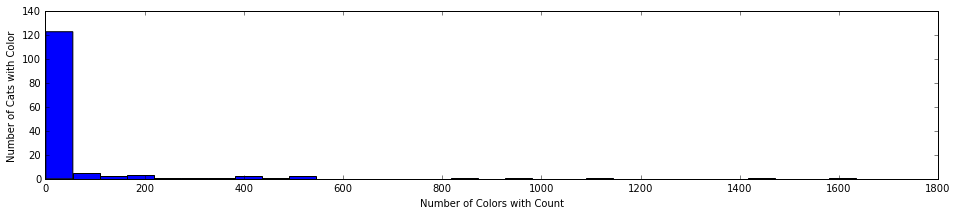

In [55]:
cat_color_outcomes = groupCountFractionals(cats,"OutcomeType",["Color"])
cat_color_adoption = cat_color_outcomes[cat_color_outcomes["OutcomeType"] == "Adoption"]
plt.figure(figsize=(16,3))
plt.hist(cat_color_adoption.OuterCount.values,bins=30)
plt.ylabel("Number of Cats with Color")
plt.xlabel("Number of Colors with Count")

**Most colors appear only a small number of times**

In [56]:
#Checking for typos and alternative spellings etc
colors = cats.Color.unique()
colors = [c.split("/") for c in colors]
colors = [item for sublist in colors for item in sublist]
sorted(list(set(colors)))

['Agouti',
 'Apricot',
 'Black',
 'Black Smoke',
 'Black Tabby',
 'Black Tiger',
 'Blue',
 'Blue Cream',
 'Blue Point',
 'Blue Smoke',
 'Blue Tabby',
 'Brown',
 'Brown Tabby',
 'Brown Tiger',
 'Buff',
 'Calico',
 'Calico Point',
 'Chocolate',
 'Chocolate Point',
 'Cream',
 'Cream Tabby',
 'Flame Point',
 'Gray',
 'Gray Tabby',
 'Lilac Point',
 'Lynx Point',
 'Orange',
 'Orange Tabby',
 'Orange Tiger',
 'Pink',
 'Seal Point',
 'Silver',
 'Silver Lynx Point',
 'Silver Tabby',
 'Tan',
 'Torbie',
 'Tortie',
 'Tortie Point',
 'Tricolor',
 'White',
 'Yellow']

In [57]:
len(cat_color_adoption[cat_color_adoption.OuterCount > 10]["Color"].unique())

50

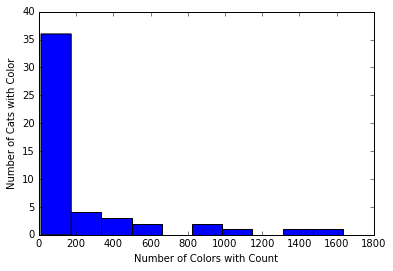

In [58]:
plt.hist(cat_color_adoption[cat_color_adoption.OuterCount > 10].OuterCount.values)
plt.ylabel("Number of Cats with Color")
plt.xlabel("Number of Colors with Count")

In [59]:
common_colors = cat_color_adoption[cat_color_adoption.OuterCount > 50].Color.values

In [32]:
def annotateCommonColors(color):
    if color in common_colors:
        return "Color"+ color
    else:
        return "RareColor"

In [60]:
cats["CColor"] = cats.Color.apply(annotateCommonColors)

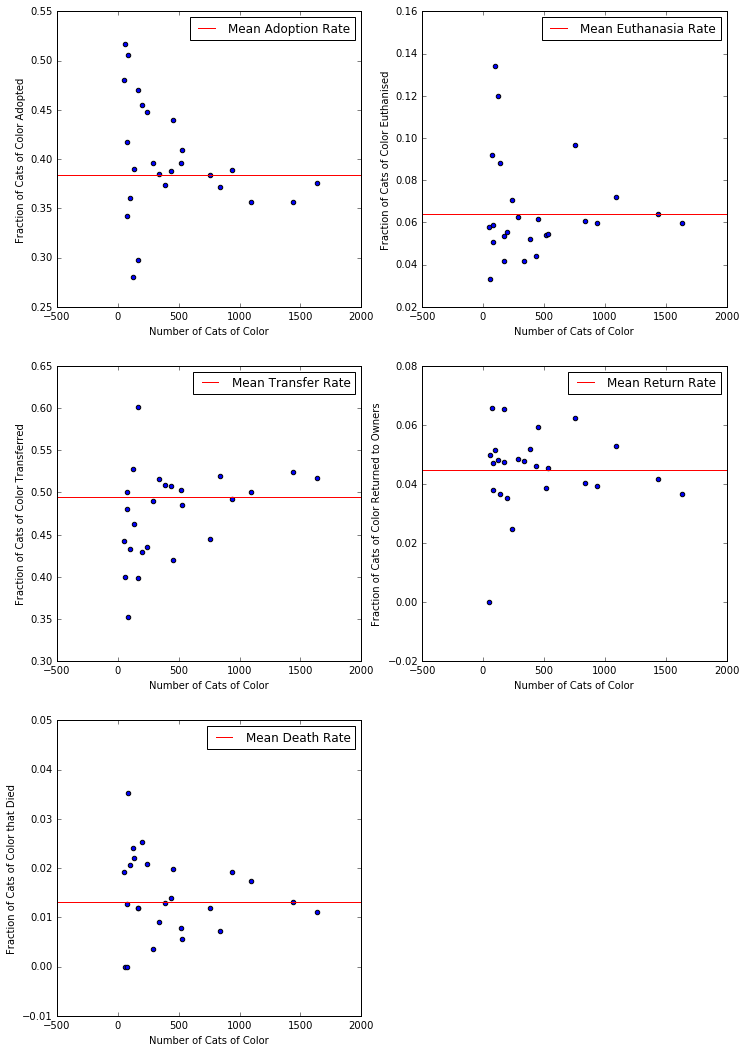

In [61]:
cat_color_outcomes = groupCountFractionals(cats,"OutcomeType",["CColor"])
cat_color_adoption = cat_color_outcomes[cat_color_outcomes.OutcomeType == "Adoption"]
cat_color_adoption = cat_color_adoption.sort_values(["CColor"])
cat_color_counts = cat_color_adoption.OuterCount.values                                       
cat_color_transfer = cat_color_outcomes[cat_color_outcomes.OutcomeType == "Transfer"].sort_values(["CColor"])
cat_color_euthanasia = cat_color_outcomes[cat_color_outcomes.OutcomeType == "Euthanasia"].sort_values(["CColor"])
cat_color_return = cat_color_outcomes[cat_color_outcomes.OutcomeType == "Return_to_owner"].sort_values(["CColor"])
cat_color_died = cat_color_outcomes[cat_color_outcomes.OutcomeType == "Died"].sort_values(["CColor"])


common_colors = sorted(common_colors)

plt.figure(figsize=(12,18))                                           
plt.subplot(321)
plt.scatter(cat_color_adoption.OuterCount.values,cat_color_adoption.Fraction.values)
mean_adopt = np.sum(cat_color_adoption.InnerCount)/np.sum(cat_color_adoption.OuterCount)
plt.axhline(mean_adopt,c='r',label = "Mean Adoption Rate")
plt.legend()
plt.xlabel("Number of Cats of Color")
plt.ylabel("Fraction of Cats of Color Adopted")


plt.subplot(322)
plt.scatter(cat_color_euthanasia.OuterCount.values,cat_color_euthanasia.Fraction.values)
mean_euthanasia = np.sum(cat_color_euthanasia.InnerCount)/np.sum(cat_color_euthanasia.OuterCount)
plt.axhline(mean_euthanasia,c='r',label = "Mean Euthanasia Rate")
plt.legend()
plt.xlabel("Number of Cats of Color")
plt.ylabel("Fraction of Cats of Color Euthanised")

plt.subplot(323)
plt.scatter(cat_color_transfer.OuterCount.values,cat_color_transfer.Fraction.values)
mean_transfer = np.sum(cat_color_transfer.InnerCount)/np.sum(cat_color_transfer.OuterCount)
plt.axhline(mean_transfer,c='r',label = "Mean Transfer Rate")
plt.legend()
plt.xlabel("Number of Cats of Color")
plt.ylabel("Fraction of Cats of Color Transferred")

plt.subplot(324)
plt.scatter(cat_color_return.OuterCount.values,cat_color_return.Fraction.values)
mean_return = np.sum(cat_color_return.InnerCount)/np.sum(cat_color_return.OuterCount)
plt.axhline(mean_return,c='r',label = "Mean Return Rate")
plt.legend()
plt.xlabel("Number of Cats of Color")
plt.ylabel("Fraction of Cats of Color Returned to Owners")

plt.subplot(325)
plt.scatter(cat_color_died.OuterCount.values,cat_color_died.Fraction.values)
mean_died = np.sum(cat_color_died.InnerCount)/np.sum(cat_color_died.OuterCount)
plt.axhline(mean_died,c='r',label = "Mean Death Rate")
plt.legend()
plt.xlabel("Number of Cats of Color")
plt.ylabel("Fraction of Cats of Color that Died")




**There is one color that is both reasonably common and has a distinctly elevated euthanasia rate.**

In [62]:
cat_color_euthanasia[(cat_color_euthanasia.OuterCount > 500) & (cat_color_euthanasia.Fraction > 0.08)]

,CColor,Fraction,InnerCount,OutcomeType,OuterCount
119,RareColor,0.096689,73,Euthanasia,755


In [63]:
cat_euths = cats[cats.OutcomeType == "Euthanasia"]
cat_euth_color_sub = groupCountFractionals(cat_euths,"OutcomeSubtype",["CColor"])

In [64]:
#Population wide euthanasia reasons
cat_euth_color_sub.groupby(["OutcomeSubtype"]).agg(np.mean)

,Fraction,InnerCount,OuterCount
OutcomeSubtype,,,
0,0.000000,0.00,28.4
Aggressive,0.008475,0.12,28.4
Medical,0.030222,1.04,28.4
Rabies Risk,0.032428,1.12,28.4
Suffering,0.928467,26.08,28.4


In [65]:
#Rare color euthanasia reasons
cat_euth_color_sub[cat_euth_color_sub.CColor == "RareColor"].groupby(["OutcomeSubtype"]).agg(np.mean)

,Fraction,InnerCount,OuterCount
OutcomeSubtype,,,
0,0.000000,0,73
Aggressive,0.000000,0,73
Medical,0.054795,4,73
Rabies Risk,0.041096,3,73
Suffering,0.904110,66,73


**Cats with rare colors are more likely to be euthanised.There is some indication that these animals are more prone to medical conditions leading to euthanasia, but this is not conclusive.**

**Dog Colors**

In [50]:
len(dogs_with_ukc.Color.unique())

232

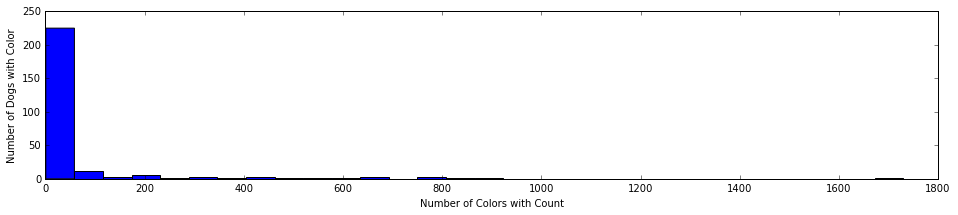

In [48]:
dog_color_outcomes = groupCountFractionals(dogs,"OutcomeType",["Color"])
dog_color_adoption = dog_color_outcomes[dog_color_outcomes["OutcomeType"] == "Adoption"]
plt.figure(figsize=(16,3))
plt.hist(dog_color_adoption.OuterCount.values,bins=30)
plt.ylabel("Number of Dogs with Color")
plt.xlabel("Number of Colors with Count")

In [40]:
#Checking for typos and alternative spellings etc
colors = dogs.Color.unique()
colors = [c.split("/") for c in colors]
colors = [item for sublist in colors for item in sublist]
sorted(list(set(colors)))

['Apricot',
 'Black',
 'Black Brindle',
 'Black Smoke',
 'Black Tiger',
 'Blue',
 'Blue Cream',
 'Blue Merle',
 'Blue Smoke',
 'Blue Tick',
 'Blue Tiger',
 'Brown',
 'Brown Brindle',
 'Brown Merle',
 'Brown Tabby',
 'Brown Tiger',
 'Buff',
 'Chocolate',
 'Cream',
 'Fawn',
 'Gold',
 'Gray',
 'Liver',
 'Liver Tick',
 'Orange',
 'Pink',
 'Red',
 'Red Merle',
 'Red Tick',
 'Ruddy',
 'Sable',
 'Silver',
 'Tan',
 'Tricolor',
 'White',
 'Yellow',
 'Yellow Brindle']

In [61]:
common_dog_colors = dog_color_adoption[dog_color_adoption.OuterCount > 10]["Color"].values
def annotateCommonColors(color):
    if color in common_dog_colors:
        return "Color"+ color
    else:
        return "RareColor"
dogs["CColor"] = dogs.Color.apply(annotateCommonColors)


In [62]:
dog_color_outcomes = groupCountFractionals(dogs,"OutcomeType",["CColor"])
dog_color_adoption = dog_color_outcomes[dog_color_outcomes.OutcomeType == "Adoption"]
dog_color_adoption = dog_color_adoption.sort_values(["CColor"])
dog_color_counts = dog_color_adoption.OuterCount.values                                       
dog_color_transfer = dog_color_outcomes[dog_color_outcomes.OutcomeType == "Transfer"].sort_values(["CColor"])
dog_color_euthanasia = dog_color_outcomes[dog_color_outcomes.OutcomeType == "Euthanasia"].sort_values(["CColor"])
dog_color_return = dog_color_outcomes[dog_color_outcomes.OutcomeType == "Return_to_owner"].sort_values(["CColor"])
dog_color_died = dog_color_outcomes[dog_color_outcomes.OutcomeType == "Died"].sort_values(["CColor"])


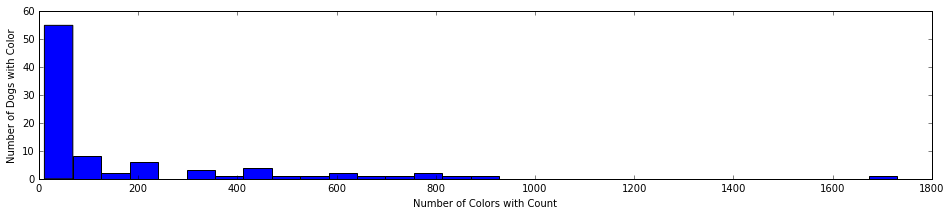

In [63]:
plt.figure(figsize=(16,3))
plt.hist(dog_color_adoption.OuterCount.values,bins=30)
plt.ylabel("Number of Dogs with Color")
plt.xlabel("Number of Colors with Count")

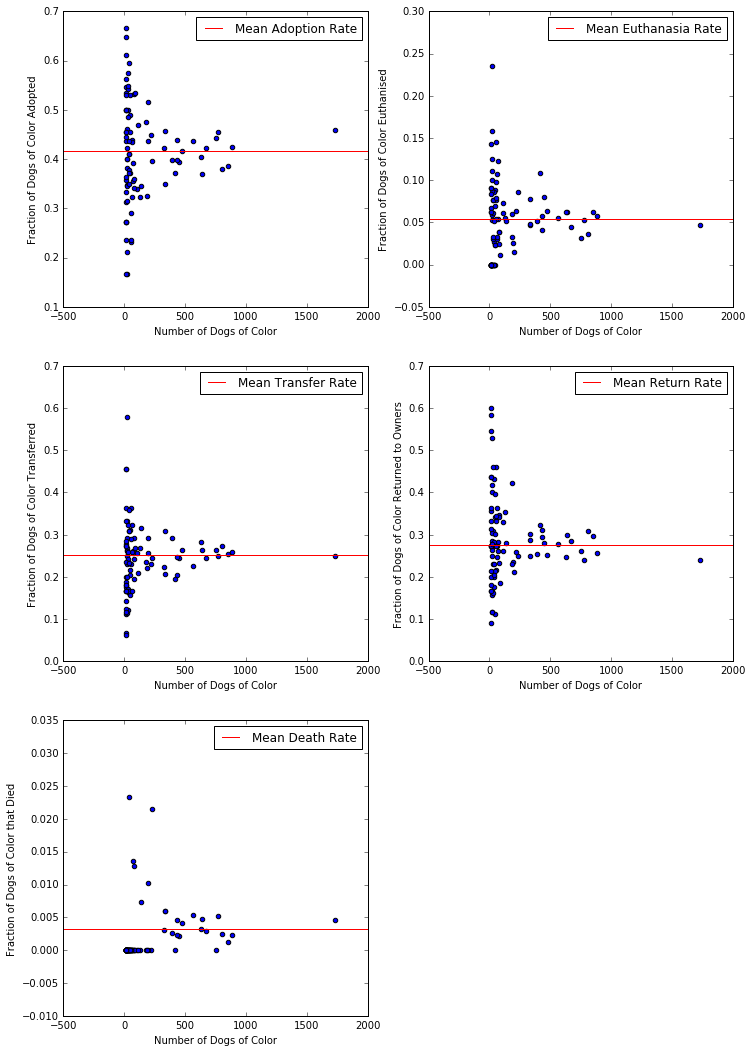

In [64]:
dog_color_outcomes = groupCountFractionals(dogs,"OutcomeType",["CColor"])
dog_color_adoption = dog_color_outcomes[dog_color_outcomes.OutcomeType == "Adoption"]
dog_color_adoption = dog_color_adoption.sort_values(["CColor"])
dog_color_counts = dog_color_adoption.OuterCount.values                                       
dog_color_transfer = dog_color_outcomes[dog_color_outcomes.OutcomeType == "Transfer"].sort_values(["CColor"])
dog_color_euthanasia = dog_color_outcomes[dog_color_outcomes.OutcomeType == "Euthanasia"].sort_values(["CColor"])
dog_color_return = dog_color_outcomes[dog_color_outcomes.OutcomeType == "Return_to_owner"].sort_values(["CColor"])
dog_color_died = dog_color_outcomes[dog_color_outcomes.OutcomeType == "Died"].sort_values(["CColor"])


common_colors = sorted(common_dog_colors)

plt.figure(figsize=(12,18))                                           
plt.subplot(321)
plt.scatter(dog_color_adoption.OuterCount.values,dog_color_adoption.Fraction.values)
mean_adopt = np.sum(dog_color_adoption.InnerCount)/np.sum(dog_color_adoption.OuterCount)
plt.axhline(mean_adopt,c='r',label = "Mean Adoption Rate")
plt.legend()
plt.xlabel("Number of Dogs of Color")
plt.ylabel("Fraction of Dogs of Color Adopted")


plt.subplot(322)
plt.scatter(dog_color_euthanasia.OuterCount.values,dog_color_euthanasia.Fraction.values)
mean_euthanasia = np.sum(dog_color_euthanasia.InnerCount)/np.sum(dog_color_euthanasia.OuterCount)
plt.axhline(mean_euthanasia,c='r',label = "Mean Euthanasia Rate")
plt.legend()
plt.xlabel("Number of Dogs of Color")
plt.ylabel("Fraction of Dogs of Color Euthanised")

plt.subplot(323)
plt.scatter(dog_color_transfer.OuterCount.values,dog_color_transfer.Fraction.values)
mean_transfer = np.sum(dog_color_transfer.InnerCount)/np.sum(dog_color_transfer.OuterCount)
plt.axhline(mean_transfer,c='r',label = "Mean Transfer Rate")
plt.legend()
plt.xlabel("Number of Dogs of Color")
plt.ylabel("Fraction of Dogs of Color Transferred")

plt.subplot(324)
plt.scatter(dog_color_return.OuterCount.values,dog_color_return.Fraction.values)
mean_return = np.sum(dog_color_return.InnerCount)/np.sum(dog_color_return.OuterCount)
plt.axhline(mean_return,c='r',label = "Mean Return Rate")
plt.legend()
plt.xlabel("Number of Dogs of Color")
plt.ylabel("Fraction of Dogs of Color Returned to Owners")

plt.subplot(325)
plt.scatter(dog_color_died.OuterCount.values,dog_color_died.Fraction.values)
mean_died = np.sum(dog_color_died.InnerCount)/np.sum(dog_color_died.OuterCount)
plt.axhline(mean_died,c='r',label = "Mean Death Rate")
plt.legend()
plt.xlabel("Number of Dogs of Color")
plt.ylabel("Fraction of Dogs of Color that Died")




# Temporal Clustering

**I have a suspicion that events might occur in clusters (eg a whole bunch of cats get put in a van and transferred in one hit). This was supported by the patterns seen earlier in the hour-day plots.**

In [66]:
cats = cats.sort_values("CumulativeTime")
dogs = dogs.sort_values("CumulativeTime")


In [69]:
last_euth = 0
last_adopt = 0
last_transfer=0
last_death = 0
last_return = 0

def annotateIntervals(row):
    global last_adopt
    global last_euth
    global last_transfer
    global last_death
    global last_return
    row_time = row.CumulativeTime
    row.loc["LastAdopt"] = row_time - last_adopt
    row.loc["LastTransfer"] = row_time - last_transfer
    row.loc["LastEuthanasia"] = row_time - last_euth
    row.loc["LastDeath"] = row_time - last_death
    row.loc["LastReturn"] = row_time - last_return
    row_event = row.OutcomeType
    if row_event == "Adoption":
        last_adopt = row_time
    elif row_event == "Euthanasia":
        last_euth = row_time
    elif row_event == "Transfer":
        last_transfer = row_time
    elif row_event == "Return_to_owner":
        last_return = row_time
    elif row_event == "Died":
        last_death = row_time
    return row

dogs = dogs.apply(annotateIntervals,axis=1)

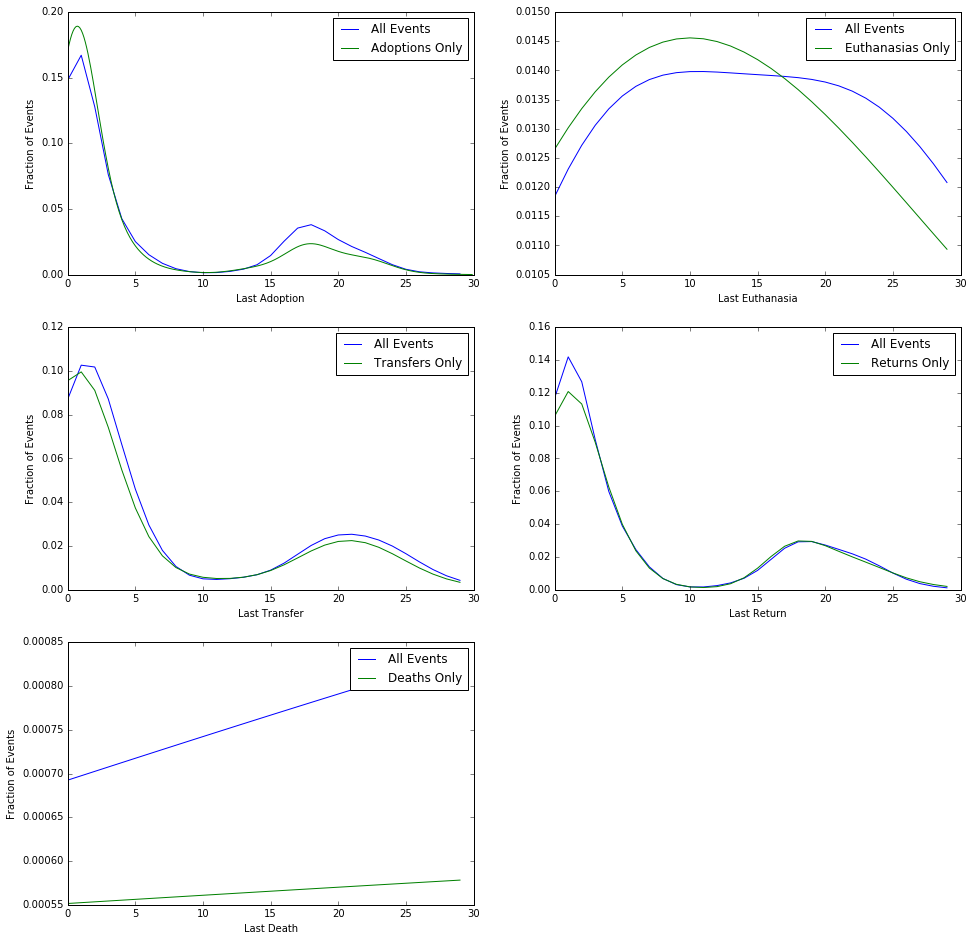

In [59]:
plt.figure(figsize=(16,16))
plt.subplot(321)
density = kde.gaussian_kde(dogs.LastAdopt.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="All Events")
adopt_only = dogs[dogs.OutcomeType == "Adoption"]
density = kde.gaussian_kde(adopt_only.LastAdopt.values)
x = np.arange(0,30,0.1)
plt.plot(x,density(x),label="Adoptions Only")
plt.xlabel("Last Adoption")
plt.ylabel("Fraction of Events")
plt.legend()

plt.subplot(322)
density = kde.gaussian_kde(dogs.LastEuthanasia.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="All Events")
adopt_only = dogs[dogs.OutcomeType == "Euthanasia"]
density = kde.gaussian_kde(adopt_only.LastEuthanasia.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="Euthanasias Only")
plt.xlabel("Last Euthanasia")
plt.ylabel("Fraction of Events")
plt.legend()


plt.subplot(323)
density = kde.gaussian_kde(dogs.LastTransfer.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="All Events")
adopt_only = dogs[dogs.OutcomeType == "Transfer"]
density = kde.gaussian_kde(adopt_only.LastTransfer.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="Transfers Only")
plt.xlabel("Last Transfer")
plt.ylabel("Fraction of Events")
plt.legend()

plt.subplot(324)
density = kde.gaussian_kde(dogs.LastReturn.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="All Events")
adopt_only = dogs[dogs.OutcomeType == "Return_to_owner"]
density = kde.gaussian_kde(adopt_only.LastReturn.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="Returns Only")
plt.xlabel("Last Return")
plt.ylabel("Fraction of Events")
plt.legend()


plt.subplot(325)
density = kde.gaussian_kde(dogs.LastDeath.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="All Events")
adopt_only = dogs[dogs.OutcomeType == "Died"]
density = kde.gaussian_kde(adopt_only.LastDeath.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="Deaths Only")
plt.xlabel("Last Death")
plt.ylabel("Fraction of Events")
plt.legend()

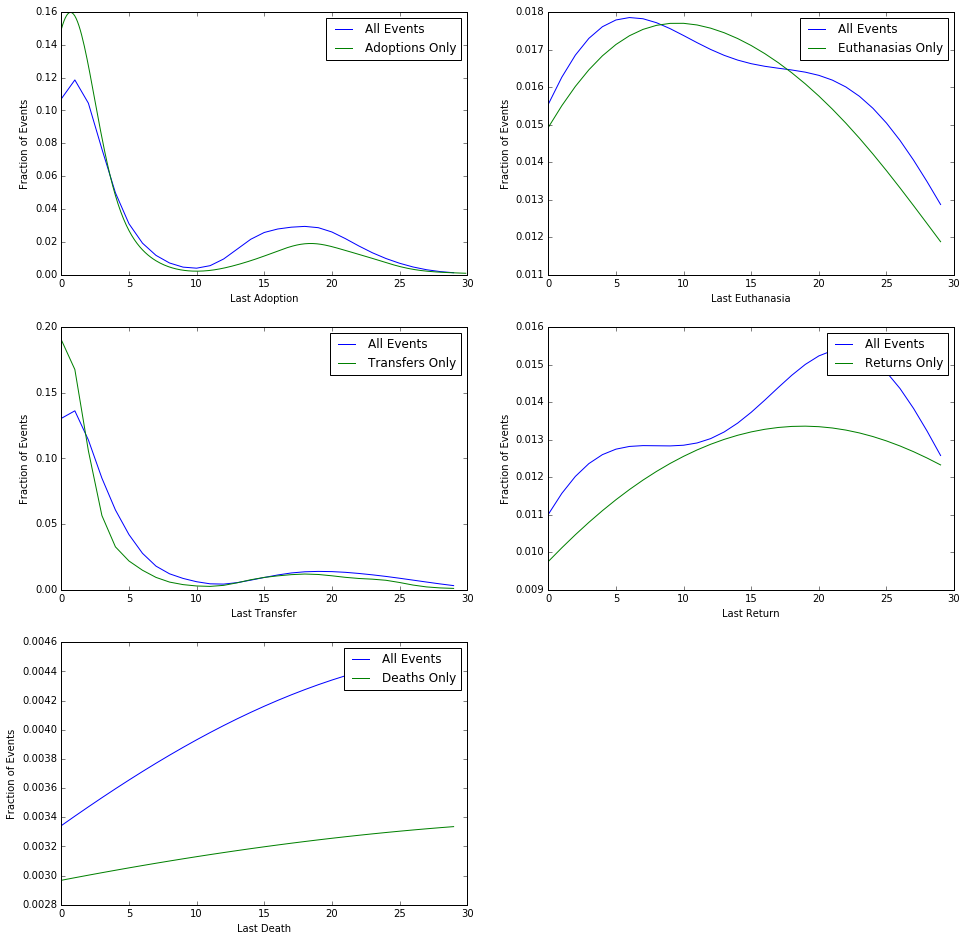

In [68]:
last_euth = 0
last_adopt = 0
last_transfer=0
last_death = 0
last_return = 0

def annotateIntervals(row):
    global last_adopt
    global last_euth
    global last_transfer
    global last_death
    global last_return
    row_time = row.CumulativeTime
    row.loc["LastAdopt"] = row_time - last_adopt
    row.loc["LastTransfer"] = row_time - last_transfer
    row.loc["LastEuthanasia"] = row_time - last_euth
    row.loc["LastDeath"] = row_time - last_death
    row.loc["LastReturn"] = row_time - last_return
    row_event = row.OutcomeType
    if row_event == "Adoption":
        last_adopt = row_time
    elif row_event == "Euthanasia":
        last_euth = row_time
    elif row_event == "Transfer":
        last_transfer = row_time
    elif row_event == "Return_to_owner":
        last_return = row_time
    elif row_event == "Died":
        last_death = row_time
    return row

cats = cats.apply(annotateIntervals,axis=1)
plt.figure(figsize=(16,16))
plt.subplot(321)
density = kde.gaussian_kde(cats.LastAdopt.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="All Events")
adopt_only = cats[cats.OutcomeType == "Adoption"]
density = kde.gaussian_kde(adopt_only.LastAdopt.values)
x = np.arange(0,30,0.1)
plt.plot(x,density(x),label="Adoptions Only")
plt.xlabel("Last Adoption")
plt.ylabel("Fraction of Events")
plt.legend()

plt.subplot(322)
density = kde.gaussian_kde(cats.LastEuthanasia.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="All Events")
adopt_only = cats[cats.OutcomeType == "Euthanasia"]
density = kde.gaussian_kde(adopt_only.LastEuthanasia.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="Euthanasias Only")
plt.xlabel("Last Euthanasia")
plt.ylabel("Fraction of Events")
plt.legend()


plt.subplot(323)
density = kde.gaussian_kde(cats.LastTransfer.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="All Events")
adopt_only = cats[cats.OutcomeType == "Transfer"]
density = kde.gaussian_kde(adopt_only.LastTransfer.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="Transfers Only")
plt.xlabel("Last Transfer")
plt.ylabel("Fraction of Events")
plt.legend()

plt.subplot(324)
density = kde.gaussian_kde(cats.LastReturn.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="All Events")
adopt_only = cats[cats.OutcomeType == "Return_to_owner"]
density = kde.gaussian_kde(adopt_only.LastReturn.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="Returns Only")
plt.xlabel("Last Return")
plt.ylabel("Fraction of Events")
plt.legend()


plt.subplot(325)
density = kde.gaussian_kde(cats.LastDeath.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="All Events")
adopt_only = cats[cats.OutcomeType == "Died"]
density = kde.gaussian_kde(adopt_only.LastDeath.values)
x = np.arange(0,30,1)
plt.plot(x,density(x),label="Deaths Only")
plt.xlabel("Last Death")
plt.ylabel("Fraction of Events")
plt.legend()

# Checking the time distributions of the training and testing sets.


In [61]:
test = pandas.read_csv("test.csv",encoding='utf-8')
test.DateTime = pandas.to_datetime(test.DateTime)
test["CumulativeTime"] = test.DateTime.apply(lambda x: pandas.Timedelta(x - pandas.Timestamp('2013-10-01 09:31:00'),'m') )
test.CumulativeTime = test.CumulativeTime/ np.timedelta64(1, 'h')

(array([ 1774.,  1496.,  1869.,  2337.,  1873.,  1526.,  1845.,  2383.,
         1971.,  1670.]),
 array([     0.        ,   2096.14333333,   4192.28666667,   6288.43      ,
          8384.57333333,  10480.71666667,  12576.86      ,  14673.00333333,
         16769.14666667,  18865.29      ,  20961.43333333]),
 <a list of 10 Patch objects>)

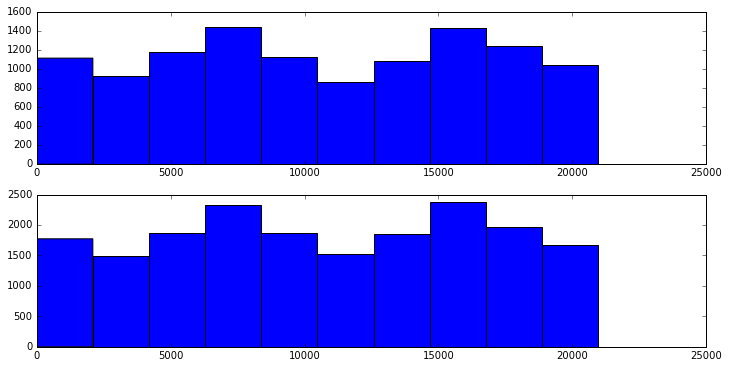

In [62]:
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.hist(test.CumulativeTime)
plt.subplot(212)
plt.hist(training.CumulativeTime)

**The training and testing sets have identical time distributions**

In [63]:
dog_type_dummies = pandas.get_dummies(dogs_with_ukc.Type2)
dog_type_dummies.columns = ["Type" + t for t in dog_type_dummies.columns]
dog_type_cols = dog_type_dummies.columns
dogs = dogs_with_ukc.join(dog_type_dummies)

In [64]:
dogs["Year"] = dogs.DateTime.dt.year
dogs.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color',
       'Age', 'Named', 'Gender', 'Fixed', 'Intact', 'UnknownFixed', 'WeekDay',
       'MonthDayFraction', 'Month', 'WeekOfYear', 'Pedigree', 'Hour', 'Year',
       'CumulativeTime', 'Day0', 'Day1', 'Day2', 'Day3', 'Day4', 'Day5',
       'Day6', 'Hour0', 'Hour5', 'Hour6', 'Hour7', 'Hour8', 'Hour9', 'Hour10',
       'Hour11', 'Hour12', 'Hour13', 'Hour14', 'Hour15', 'Hour16', 'Hour17',
       'Hour18', 'Hour19', 'Hour20', 'Hour21', 'Hour22', 'Hour23', 'Count',
       'UKC', 'Type1', 'Type2', 'IsScary', 'CColor', 'LastAdopt',
       'LastTransfer', 'LastEuthanasia', 'LastDeath', 'LastReturn',
       'TypeGundog', 'TypeHound', 'TypePastoral', 'TypeSporting Dog',
       'TypeTerrier', 'TypeToy Group', 'TypeUnknown', 'TypeUtility',
       'TypeWorking'],
      dtype='object')

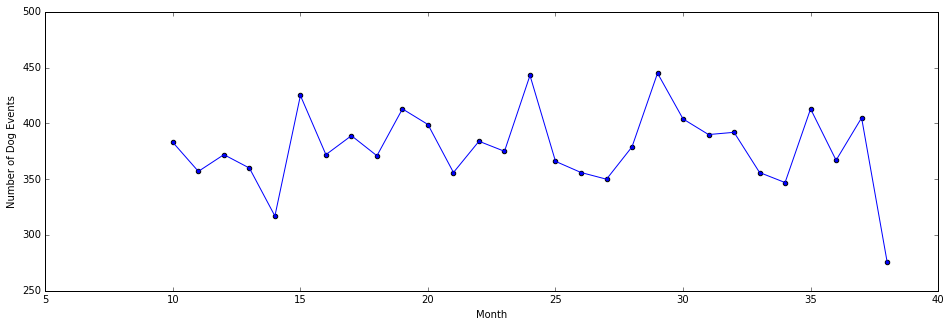

In [65]:
dogs["EventCount"] = 1
dogs_monthly_turnover = dogs.groupby(["Year","Month"]).count()["EventCount"]
dogs_monthly_turnover = dogs_monthly_turnover.reset_index()
dogs_monthly_turnover["ElapsedMonths"] = (dogs_monthly_turnover.Year- np.min(dogs_monthly_turnover.Year)) * 12 + dogs_monthly_turnover.Month

plt.figure(figsize=(16,5))
plt.plot(dogs_monthly_turnover.ElapsedMonths,dogs_monthly_turnover.EventCount)
plt.scatter(dogs_monthly_turnover.ElapsedMonths,dogs_monthly_turnover.EventCount)
plt.xlabel("Month")
plt.ylabel("Number of Dog Events")

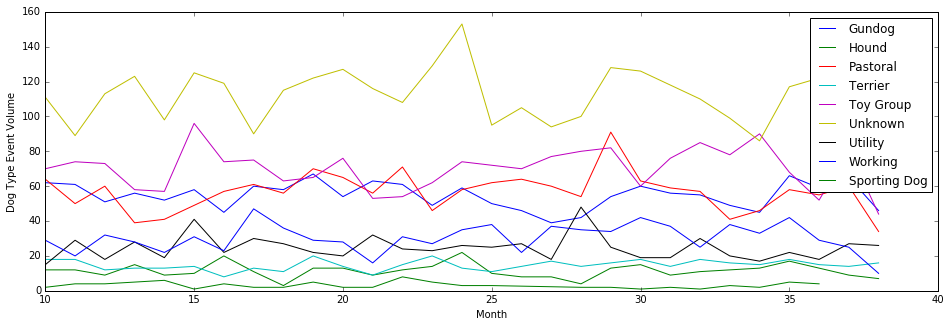

In [68]:
dogs_month_type_volumes = dogs.groupby(["Month","Year","Type2"]).agg(np.sum)["EventCount"].reset_index()
dogs_month_type_volumes["ElapsedMonths"] = (dogs_month_type_volumes.Year- np.min(dogs_month_type_volumes.Year)) * 12 + dogs_month_type_volumes.Month
plt.figure(figsize=(16,5))
for p in dogs_month_type_volumes.Type2.unique():
    d = dogs_month_type_volumes[dogs_month_type_volumes.Type2 == p].sort_values("ElapsedMonths")
    plt.plot(d.ElapsedMonths,d.EventCount,label=p)
plt.legend()
plt.xlabel("Month")
plt.ylabel("Dog Type Event Volume")

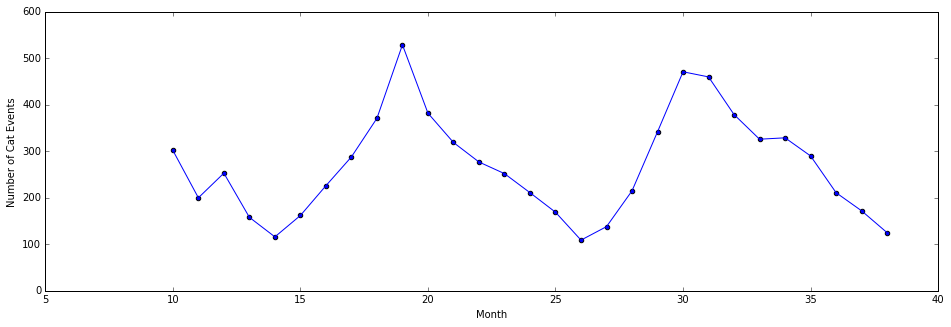

In [69]:
cats["EventCount"] = 1
cats_monthly_turnover = cats.groupby(["Year","Month"]).count()["EventCount"]
cats_monthly_turnover = cats_monthly_turnover.reset_index()
cats_monthly_turnover["ElapsedMonths"] = (cats_monthly_turnover.Year- np.min(cats_monthly_turnover.Year)) * 12 + cats_monthly_turnover.Month

plt.figure(figsize=(16,5))
plt.plot(cats_monthly_turnover.ElapsedMonths,cats_monthly_turnover.EventCount)
plt.scatter(cats_monthly_turnover.ElapsedMonths,cats_monthly_turnover.EventCount)
plt.xlabel("Month")
plt.ylabel("Number of Cat Events")

**Cats have a a strong annual pattern in terms of event volume. This is probably due to "kitten season" each year.**